In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" ## set your available devices, each use ~2G GPU-MEMORY
import sys
code_path = os.path.abspath('/home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/')
sys.path.append(os.path.abspath(code_path))

import scanpy as sc
import scMulan
from scMulan import GeneSymbolUniform

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

In [22]:
from tqdm import tqdm

## 1. load mouse adata

In [14]:
adata = sc.read('/nfs/public/cell_gpt_data/tabula_muris/tm.h5ad')
adata

AnnData object with n_obs × n_vars = 57004 × 18996
    obs: 'celltype', 'n_genes', 'counts'
    var: 'n_cells'

In [6]:
mapping_df = pd.read_csv('./mouse_mapping/mmgene_2_hsgene.txt',sep = '\t', header=None)

In [7]:
mapping_df.columns = ['mouse','human']

In [8]:
keys = mapping_df.mouse
values = mapping_df.human

In [9]:
mapping_dict = dict(zip(keys,values))

In [11]:
a = 0
for gene in adata.var_names:
    if gene not in mapping_dict.keys():
        a += 1
a

3259

In [ ]:
# Replace the gene symbol of Mouse with gene symbols of Human 
current_var_names = adata.var_names.tolist()

new_var_names = [mapping_dict.get(gene, gene) for gene in current_var_names]
adata.var_names = new_var_names

In [13]:
adata.write_h5ad('/nfs/public/cell_gpt_data/tabula_muris/tm_trans.h5ad')

## 2. transform original h5ad with uniformed genes (42117 genes)

This step transform the genes in input adata to 42117 gene symbols and reserves the corresponding gene expression values.

In [15]:
adata_GS_uniformed = GeneSymbolUniform(input_adata=adata,
                                 output_dir="/nfs/public/cell_gpt_data/tabula_muris/",
                                 output_prefix='tm')

The shape of query data is: (57004, 18996)
The length of reference gene_list is: 42117
Performing gene symbol uniform, this step may take several minutes


Processing: 100%|██████████| 18996/18996 [00:20<00:00, 944.29it/s] 

Building output data, this step may take several minutes



Processing: 100%|██████████| 15157/15157 [00:11<00:00, 1302.15it/s]


Shape of output data is (57004, 42117). It should have 42117 genes with cell number unchanged.
h5ad file saved in:/nfs/public/cell_gpt_data/tabula_muris/tm_uniformed.h5ad
report file saved in: /nfs/public/cell_gpt_data/tabula_muris/tm_report.csv


In [17]:
adata_GS_uniformed.X.max()

30227.0

## 3. process uniformed data (simply norm and log1p)

In [34]:
## you can read the saved uniformed adata

adata_GS_uniformed=sc.read_h5ad('/nfs/public/cell_gpt_data/tabula_muris/tm_uniformed.h5ad')

In [35]:
# norm and log1p count matrix
if adata_GS_uniformed.X.max() > 10:
    sc.pp.normalize_total(adata_GS_uniformed, target_sum=1e4) 
    sc.pp.log1p(adata_GS_uniformed)

## 4. load scMulan for annotation

In [4]:
# you should first download ckpt from https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1
# put it under .ckpt/ckpt_scMulan.pt
# by: wget https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1  -O ckpt/ckpt_scMulan.pt

ckp_path = '/home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/ckpt/ckpt_scMulan.pt'

In [11]:
scml = scMulan.model_inference(ckp_path,adata_GS_uniformed )

2024-11-08 14:43:41.008 | INFO     | scMulan.model.model:__init__:119 - number of parameters: 368.80M


✅ adata passed check
👸 scMulan is ready


In [13]:
import json

In [15]:
with open('./gene_set.json','w') as jfile:
    jfile.write(';'.join(scml.meta_info['gene_set']))

In [22]:
scml = scMulan.model_inference(ckp_path, adata_GS_uniformed)
base_process = scml.cuda_count()

number of parameters: 368.80M
✅ adata passed check
👸 scMulan is ready
scMulan is currently available to 4 GPUs.


In [23]:
scml.get_cell_types_and_embds_for_adata(parallel=True, n_process = base_process)

⚡ Speed up by multiprocessing with 4 processes and 4 GPUs...


In [24]:
adata_mulan = scml.adata.copy()

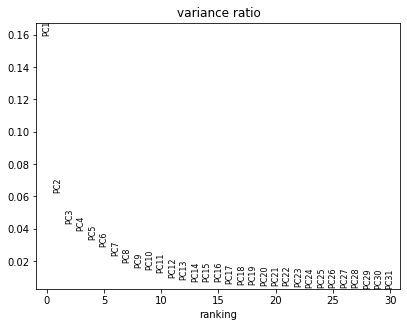

In [25]:
sc.pp.pca(adata_mulan)
sc.pl.pca_variance_ratio(adata_mulan)
sc.pp.neighbors(adata_mulan,n_pcs=10)
sc.tl.umap(adata_mulan)

In [26]:
# you can run smoothing function to filter the false positives
scMulan.cell_type_smoothing(adata_mulan, threshold=0.1)

100%|██████████| 57004/57004 [00:30<00:00, 1878.67it/s]
/home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/scMulan/utils/utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.cell_type_from_mulan_smoothing[adata.obs.smoothing_score<threshold] = "Unclassified"
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarnin

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

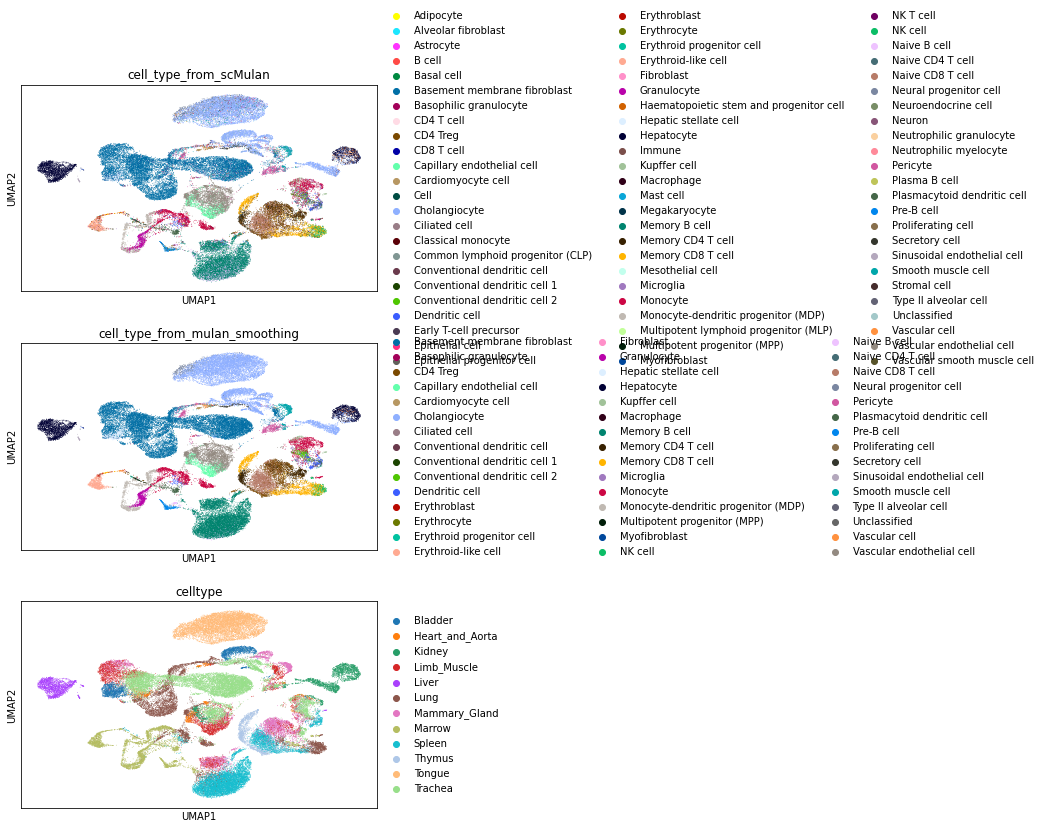

In [27]:
sc.pl.umap(adata_mulan,color=["cell_type_from_scMulan","cell_type_from_mulan_smoothing",'celltype'],ncols=1)

In [252]:
adata_mulan.write('/nfs/public/cell_gpt_data/tabula_muris/tm_anno_mulan.h5ad')

## 5. overview on the data

### Load original annotation

In [7]:
adata_meta = adata.obs.copy()

In [8]:
annotation = pd.read_csv('/nfs/public/cell_gpt_data/tabula_muris/annotations_droplet.csv',index_col=0)

/tmp/ipykernel_945746/234537212.py:1: DtypeWarning: Columns (10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  annotation = pd.read_csv('/nfs/public/cell_gpt_data/tabula_muris/annotations_droplet.csv',index_col=0)


In [9]:
for tissue in annotation.tissue.unique().tolist():
    anno_metadata = annotation[annotation['tissue'] == tissue]
    adata_meatadata = adata_meta[adata_meta['celltype'] == tissue]
    adata_name_list = adata_meatadata.index.tolist()
    adata_cell_name = [idx.split('-')[0] for idx in adata_name_list]
    print(f'tissue is {tissue}, for adata,  ori idx len is {len(adata_name_list)}, after dup is {len(set(adata_cell_name))}')
    annotation_name_list = anno_metadata.index.tolist()
    annotation_cell_name = [idx.split('_')[-1] for idx in annotation_name_list]
    print(f'tissue is {tissue}, for anno,  ori idx len is {len(annotation_name_list)}, after dup is {len(set(annotation_cell_name))}')
    print(f'intersetcion is {len(set(adata_cell_name).intersection(set(annotation_cell_name)))}')

tissue is Lung, for adata,  ori idx len is 6197, after dup is 6141
tissue is Lung, for anno,  ori idx len is 5449, after dup is 5440
intersetcion is 5440
tissue is Marrow, for adata,  ori idx len is 4112, after dup is 4107
tissue is Marrow, for anno,  ori idx len is 3652, after dup is 3648
intersetcion is 3648
tissue is Tongue, for adata,  ori idx len is 7538, after dup is 7521
tissue is Tongue, for anno,  ori idx len is 7538, after dup is 7521
intersetcion is 7521
tissue is Spleen, for adata,  ori idx len is 9573, after dup is 9542
tissue is Spleen, for anno,  ori idx len is 9552, after dup is 9522
intersetcion is 9522
tissue is Heart_and_Aorta, for adata,  ori idx len is 654, after dup is 654
tissue is Heart_and_Aorta, for anno,  ori idx len is 624, after dup is 624
intersetcion is 624
tissue is Trachea, for adata,  ori idx len is 11269, after dup is 11224
tissue is Trachea, for anno,  ori idx len is 11269, after dup is 11224
intersetcion is 0
tissue is Bladder, for adata,  ori idx l

In [10]:
adata_meatadata

celltype  n_genes  counts
AAACCTGCAGGTCCAC-1  Limb_Muscle     1934  6372.0
AAACCTGCATCAGTAC-1  Limb_Muscle      925  1825.0
AAACCTGGTGCCTGGT-1  Limb_Muscle     1435  3906.0
AAACCTGGTTATCACG-1  Limb_Muscle      948  2527.0
AAACCTGTCCCAGGTG-1  Limb_Muscle      861  2458.0
...                         ...      ...     ...
TTTGTCAAGCCAGAAC-1  Limb_Muscle     1091  2683.0
TTTGTCACAGCCTTGG-1  Limb_Muscle     1239  2589.0
TTTGTCAGTAAGGGCT-1  Limb_Muscle     2439  9056.0
TTTGTCAGTCTCCACT-1  Limb_Muscle     2296  8244.0
TTTGTCAGTTGTGGAG-1  Limb_Muscle     1131  3463.0

[4543 rows x 3 columns]

In [11]:
adata_meatadata = adata_meta[adata_meta['celltype'] == 'Marrow']
adata_name_list = adata_meatadata.index.tolist()
adata_cell_name = [idx.split('-')[0] for idx in adata_name_list]

new_index = adata_meta.index.to_series().apply(lambda x: x.split('-')[0] if adata_meta.loc[x, 'celltype'] == 'Marrow' else x)

In [12]:
tissue_to_modify = annotation.tissue.unique().tolist()

def modify_index(row):
    if row['celltype'] in tissue_to_modify:
        return row.name.split('-')[0]
    else:
        return row.name

In [13]:
new_index = adata_meta.apply(modify_index, axis=1)
adata_meta.index = new_index

In [14]:
adata_meta

celltype  n_genes   counts
AAACCTGAGCATCATC   Marrow     3470  12996.0
AAACCTGCAGAGTGTG   Marrow     1764   5437.0
AAACCTGGTCGAACAG   Marrow     1526   4466.0
AAACCTGTCACTTCAT   Marrow     4044  23853.0
AAACGGGAGAAGGTTT   Marrow      977   4375.0
...                   ...      ...      ...
736877            Trachea     2256   6507.0
736941            Trachea      772   1672.0
737147            Trachea     1302   2589.0
737253            Trachea      973   2373.0
737274            Trachea     1800   5903.0

[57004 rows x 3 columns]

In [15]:
def modify_index_anno(row):
    return row.name.split('_')[-1]

In [16]:
new_index = annotation.apply(modify_index_anno, axis=1)
annotation.index = new_index
annotation.cell_ontology_class

AAACGGGAGGATATAC                      myeloid cell
AAACGGGTCTCGTATT               alveolar macrophage
AAAGATGCAGATCTGT                            B cell
AAATGCCAGATAGTCA               natural killer cell
AAATGCCCAAACTGCT                            T cell
                                 ...              
TTTGTCAAGCCAGAAC                  endothelial cell
TTTGTCACAGCCTTGG                  endothelial cell
TTTGTCAGTAAGGGCT             mesenchymal stem cell
TTTGTCAGTCTCCACT             mesenchymal stem cell
TTTGTCAGTTGTGGAG    skeletal muscle satellite cell
Name: cell_ontology_class, Length: 55656, dtype: object

In [17]:
annotation['cell_ontology_class'] = annotation['cell_ontology_class'].astype(str)
annotation_grouped = annotation.groupby(annotation.index).agg({'cell_ontology_class': ','.join})
annotation_grouped.cell_ontology_class.value_counts()

cell_ontology_class
B cell                                                            7706
mesenchymal cell                                                  7302
basal cell of epidermis                                           4138
T cell                                                            4094
stromal cell                                                      3010
                                                                  ... 
keratinocyte,skeletal muscle satellite cell                          1
dendritic cell,nan                                                   1
early pro-B cell,luminal epithelial cell of mammary gland            1
early pro-B cell,endothelial cell                                    1
luminal epithelial cell of mammary gland,mesenchymal stem cell       1
Name: count, Length: 624, dtype: int64

In [18]:
adata_meta['tissue'] = adata_meta['celltype']
annotation = annotation[['cell_ontology_class','tissue']]

In [ ]:
import pandas as pd

consistent_counts = 0
inconsistent_counts = 0
inconsistent_entries = []

# group with tissue and check the replicated results
for tissue, group in annotation.groupby('tissue'):
    duplicated_indices = group.index[group.index.duplicated()].unique()
    for idx in duplicated_indices:
        duplicated_rows = group.loc[idx]
        if duplicated_rows['cell_ontology_class'].nunique() == 1:
            consistent_counts += 1
        else:
            inconsistent_counts += 1
            inconsistent_entries.append(duplicated_rows)

# print results
print(f"Consistent counts: {consistent_counts}")
print(f"Inconsistent counts: {inconsistent_counts}")
print("Inconsistent entries:")
for entry in inconsistent_entries:
    entry

Consistent counts: 77
Inconsistent counts: 56
Inconsistent entries:


In [20]:
inconsistent_entries

[                      cell_ontology_class   tissue
 TGTTCCGAGCTAACTC             bladder cell  Bladder
 TGTTCCGAGCTAACTC  bladder urothelial cell  Bladder,
                                                 cell_ontology_class  tissue
 GATCAGTGTCACCTAA    kidney proximal straight tubule epithelial cell  Kidney
 GATCAGTGTCACCTAA  kidney loop of Henle ascending limb epithelial...  Kidney,
                  cell_ontology_class       tissue
 CAGCGACAGATAGGAG              T cell  Limb_Muscle
 CAGCGACAGATAGGAG    endothelial cell  Limb_Muscle,
                  cell_ontology_class       tissue
 CGGCTAGGTCTTGCGG                 nan  Limb_Muscle
 CGGCTAGGTCTTGCGG    endothelial cell  Limb_Muscle,
                              cell_ontology_class       tissue
 GCTTCCAGTCTTGTCC  skeletal muscle satellite cell  Limb_Muscle
 GCTTCCAGTCTTGTCC                             nan  Limb_Muscle,
                  cell_ontology_class       tissue
 GGACAGAAGTGTTTGC    endothelial cell  Limb_Muscle
 GGACAGAAGT

In [ ]:
cleaned_annotation = pd.DataFrame()
# group with tissue and process the replicated values
for tissue, group in tqdm(annotation.groupby('tissue')):
    for idx, sub_group in group.groupby(group.index):
        if sub_group['cell_ontology_class'].nunique() == 1:
            cleaned_annotation = pd.concat([cleaned_annotation, sub_group.head(1)])
        else:
            cleaned_annotation = pd.concat([cleaned_annotation, sub_group.head(1)])

# reset the index
cleaned_annotation = cleaned_annotation.reset_index().drop_duplicates().set_index('index')

print(cleaned_annotation)

100%|██████████| 12/12 [00:37<00:00,  3.14s/it]

                      cell_ontology_class   tissue
index                                             
AAACCTGCAGACAAGC  bladder urothelial cell  Bladder
AAACCTGTCTAACCGA  bladder urothelial cell  Bladder
AAACGGGAGATCCCAT  bladder urothelial cell  Bladder
AAACGGGCAGTACACT  bladder urothelial cell  Bladder
AAACGGGGTGCAACGA         endothelial cell  Bladder
...                                   ...      ...
TTTGTCATCGGCGCAT         mesenchymal cell  Trachea
TTTGTCATCGGCTTGG         endothelial cell  Trachea
TTTGTCATCTAACTGG         mesenchymal cell  Trachea
TTTGTCATCTTACCGC         mesenchymal cell  Trachea
TTTGTCATCTTGTTTG         mesenchymal cell  Trachea

[55523 rows x 2 columns]


In [24]:
cleaned_annotation

cell_ontology_class   tissue
index                                             
AAACCTGCAGACAAGC  bladder urothelial cell  Bladder
AAACCTGTCTAACCGA  bladder urothelial cell  Bladder
AAACGGGAGATCCCAT  bladder urothelial cell  Bladder
AAACGGGCAGTACACT  bladder urothelial cell  Bladder
AAACGGGGTGCAACGA         endothelial cell  Bladder
...                                   ...      ...
TTTGTCATCGGCGCAT         mesenchymal cell  Trachea
TTTGTCATCGGCTTGG         endothelial cell  Trachea
TTTGTCATCTAACTGG         mesenchymal cell  Trachea
TTTGTCATCTTACCGC         mesenchymal cell  Trachea
TTTGTCATCTTGTTTG         mesenchymal cell  Trachea

[55523 rows x 2 columns]

In [25]:
adata_meta['cell_ontology_class'] = 'Unclassified'

In [ ]:
# group with tissue
for tissue in tqdm(adata_meta['tissue'].unique()):
    adata_meta_group = adata_meta[adata_meta['tissue'] == tissue]
    annotation_group = cleaned_annotation[cleaned_annotation['tissue'] == tissue]
    
    for idx in adata_meta_group.index:
        if idx in annotation_group.index:
            adata_meta.at[idx, 'cell_ontology_class'] = annotation_group.at[idx, 'cell_ontology_class']

print(adata_meta)

100%|██████████| 12/12 [00:33<00:00,  2.77s/it]

                 celltype  n_genes   counts   tissue  \
AAACCTGAGCATCATC   Marrow     3470  12996.0   Marrow   
AAACCTGCAGAGTGTG   Marrow     1764   5437.0   Marrow   
AAACCTGGTCGAACAG   Marrow     1526   4466.0   Marrow   
AAACCTGTCACTTCAT   Marrow     4044  23853.0   Marrow   
AAACGGGAGAAGGTTT   Marrow      977   4375.0   Marrow   
...                   ...      ...      ...      ...   
736877            Trachea     2256   6507.0  Trachea   
736941            Trachea      772   1672.0  Trachea   
737147            Trachea     1302   2589.0  Trachea   
737253            Trachea      973   2373.0  Trachea   
737274            Trachea     1800   5903.0  Trachea   

                           cell_ontology_class  
AAACCTGAGCATCATC     Fraction A pre-pro B cell  
AAACCTGCAGAGTGTG                      monocyte  
AAACCTGGTCGAACAG                   promonocyte  
AAACCTGTCACTTCAT  hematopoietic precursor cell  
AAACGGGAGAAGGTTT                   granulocyte  
...                              

In [27]:
adata_meta.cell_ontology_class.value_counts()

cell_ontology_class
Unclassified                                           12518
B cell                                                  8061
basal cell of epidermis                                 4557
T cell                                                  4396
stromal cell                                            3251
keratinocyte                                            3150
hepatocyte                                              1861
endothelial cell                                        1844
immature T cell                                         1445
macrophage                                              1292
kidney proximal straight tubule epithelial cell         1225
bladder cell                                            1216
bladder urothelial cell                                 1148
mesenchymal stem cell                                   1124
natural killer cell                                     1034
nan                                                      785
gran

### re-visualize annotation from scMulan

In [30]:
adata_mulan.obs_names = adata_meta.index
adata_mulan.obs['cell_type'] = adata_meta['cell_ontology_class']
adata_mulan.obs['tissue'] = adata_mulan.obs['celltype']

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values

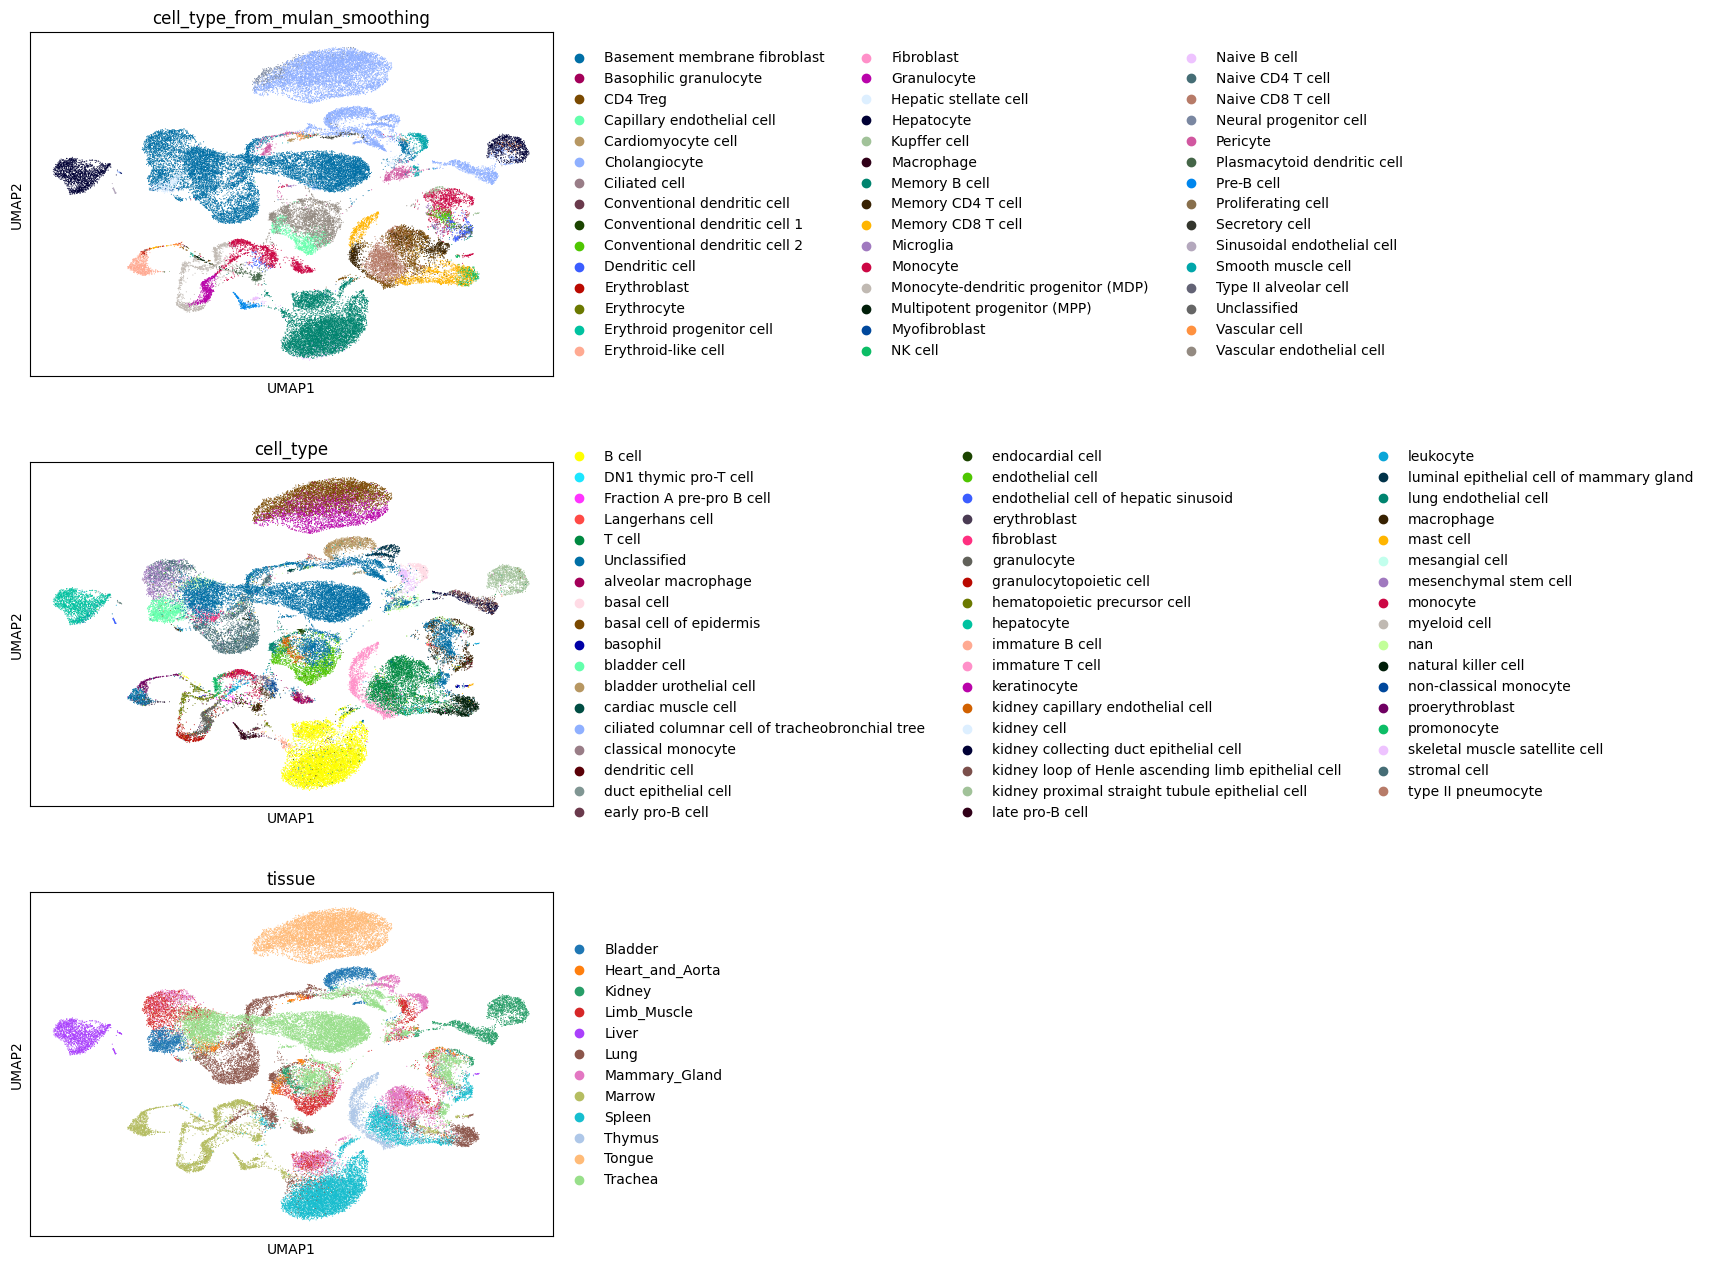

In [31]:
sc.pl.umap(adata_mulan,color=["cell_type_from_mulan_smoothing",'cell_type','tissue',],ncols=1)

In [32]:
adata_meta.tissue.value_counts()

tissue
Trachea            11269
Spleen              9573
Tongue              7538
Lung                6197
Limb_Muscle         4543
Mammary_Gland       4481
Marrow              4112
Kidney              2782
Bladder             2500
Liver               1924
Thymus              1431
Heart_and_Aorta      654
Name: count, dtype: int64

In [36]:
adata_raw = adata_GS_uniformed.copy()
adata_raw.obs = adata_mulan.obs

### leiden clustering

#### subset data with annotation

In [37]:
adata_mulan.obs.cell_type.fillna('Unclassified')

AAACCTGAGCATCATC       Fraction A pre-pro B cell
AAACCTGCAGAGTGTG                        monocyte
AAACCTGGTCGAACAG                     promonocyte
AAACCTGTCACTTCAT    hematopoietic precursor cell
AAACGGGAGAAGGTTT                     granulocyte
                                ...             
736877                              Unclassified
736941                              Unclassified
737147                              Unclassified
737253                              Unclassified
737274                              Unclassified
Name: cell_type, Length: 57004, dtype: category
Categories (53, object): ['B cell', 'DN1 thymic pro-T cell', 'Fraction A pre-pro B cell', 'Langerhans cell', ..., 'promonocyte', 'skeletal muscle satellite cell', 'stromal cell', 'type II pneumocyte']

In [38]:
adata_all_ct = adata_mulan[adata_mulan.obs.cell_type!='Unclassified',:].copy()

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [39]:
adata_all_ct_raw = adata_raw[adata_raw.obs.cell_type!='Unclassified',:].copy()

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### get umap

In [40]:
adata_all_ct_raw

AnnData object with n_obs × n_vars = 44486 × 42117
    obs: 'celltype', 'n_genes', 'counts', 'cell_type_from_scMulan', 'cell_type_from_mulan_smoothing', 'smoothing_score', 'cell_type', 'tissue'
    uns: 'log1p'

In [41]:
sc.pp.highly_variable_genes(adata_all_ct_raw,n_top_genes=5000)

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [42]:
adata_all_ct

AnnData object with n_obs × n_vars = 44486 × 2000
    obs: 'celltype', 'n_genes', 'counts', 'cell_type_from_scMulan', 'cell_type_from_mulan_smoothing', 'smoothing_score', 'cell_type', 'tissue'
    uns: 'Smoothing', 'cell_type_colors', 'cell_type_from_mulan_smoothing_colors', 'cell_type_from_scMulan_colors', 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap', 'tissue_colors'
    obsm: 'X_pca', 'X_scMulan', 'X_umap'
    varm: 'PCs'
    obsp: 'Smoothing_connectivities', 'Smoothing_distances', 'connectivities', 'distances'

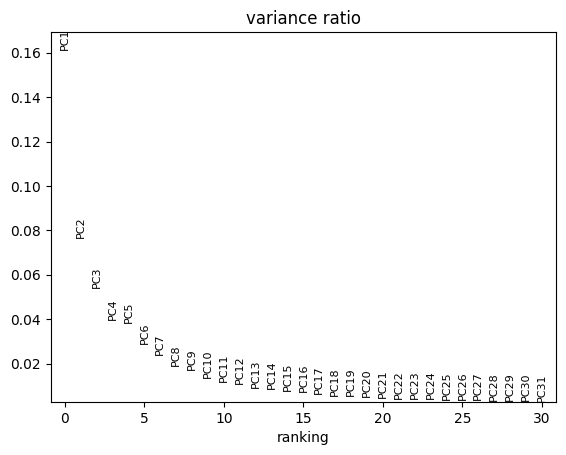

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [43]:
sc.pp.pca(adata_all_ct)
sc.pl.pca_variance_ratio(adata_all_ct)
sc.pp.neighbors(adata_all_ct,n_pcs=12)
sc.tl.umap(adata_all_ct)

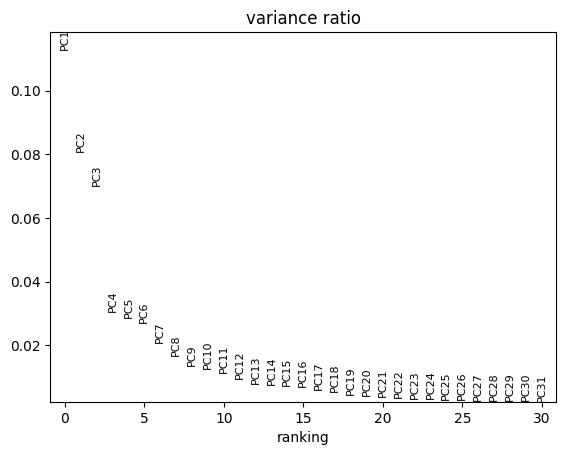

In [44]:
sc.pp.pca(adata_all_ct_raw,use_highly_variable=True)
sc.pl.pca_variance_ratio(adata_all_ct_raw)
sc.pp.neighbors(adata_all_ct_raw,n_pcs=12)
sc.tl.umap(adata_all_ct_raw)

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


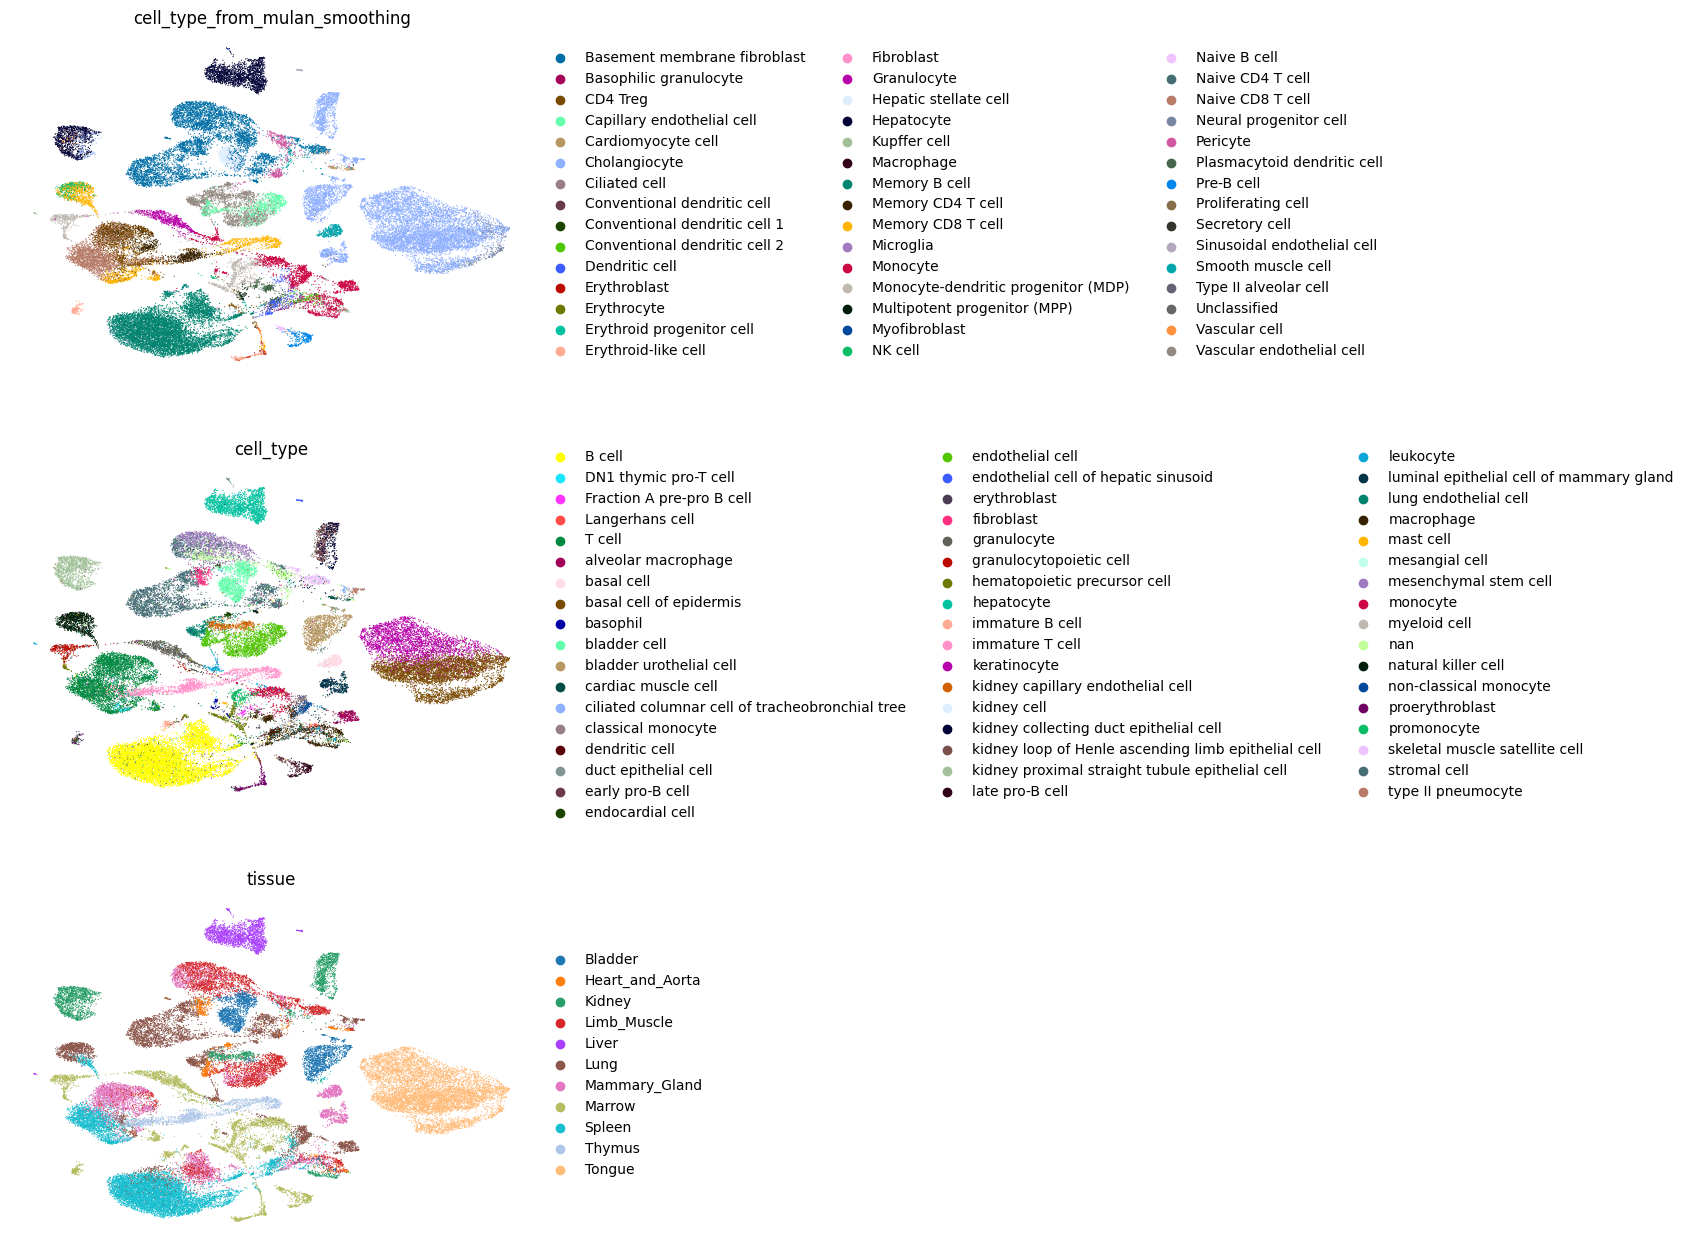

In [219]:
sc.pl.umap(adata_all_ct,color=["cell_type_from_mulan_smoothing",'cell_type','tissue',],ncols=1, frameon=False, save="all_scMulan_embedding.pdf")

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

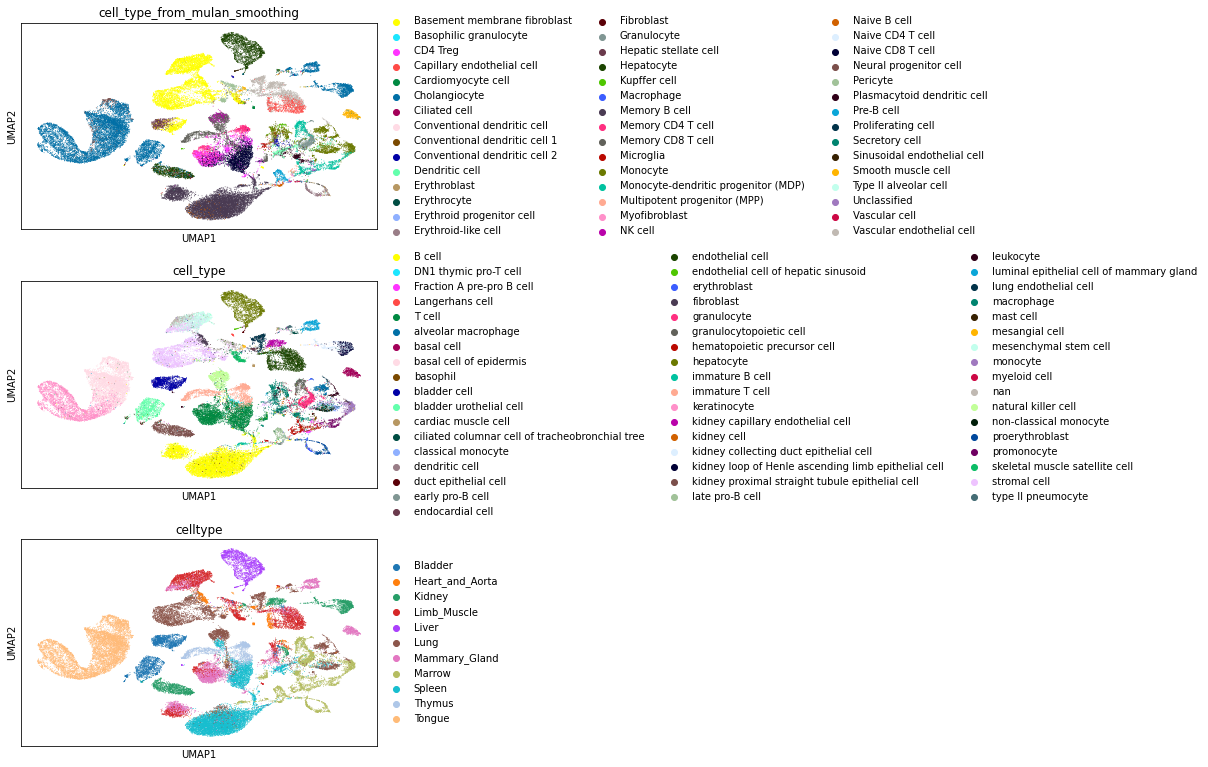

In [513]:
sc.pl.umap(adata_all_ct_raw,color=["cell_type_from_mulan_smoothing",'cell_type','tissue',],ncols=1)

In [472]:
print(len(set(adata_all_ct.obs['cell_type'])))

52


### calculate clustering metric

In [46]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

#### cell type

In [ ]:
sc.pp.neighbors(adata_all_ct, use_rep='X_scMulan')

In [ ]:
sc.pp.neighbors(adata_all_ct_raw, use_rep='X_pca')

In [52]:
sc.tl.leiden(adata_all_ct_raw, resolution=0.73)  # 调整resolution参数以改变聚类的紧密程度
# 提取 Leiden 聚类结果和真实标签
predicted_labels = adata_all_ct_raw.obs['leiden']
print(len(set(predicted_labels)))

50


In [53]:
true_labels = adata_all_ct.obs['cell_type'].tolist()
predicted_labels = adata_all_ct.obs['leiden'].tolist()

In [ ]:
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
ami = adjusted_mutual_info_score(true_labels, predicted_labels)

print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Normalized Mutual Information (NMI): {nmi}')
print(f'Adjusted Mutual Information (AMI): {ami}')

Adjusted Rand Index (ARI): 0.5192278313710896
Normalized Mutual Information (NMI): 0.7707277455959708
Adjusted Mutual Information (AMI): 0.768694960721189


In [55]:
true_labels = adata_all_ct_raw.obs['cell_type'].tolist()
predicted_labels = adata_all_ct_raw.obs['leiden'].tolist()

In [ ]:
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
ami = adjusted_mutual_info_score(true_labels, predicted_labels)

print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Normalized Mutual Information (NMI): {nmi}')
print(f'Adjusted Mutual Information (AMI): {ami}')

Adjusted Rand Index (ARI): 0.573164892651968
Normalized Mutual Information (NMI): 0.7794143558345177
Adjusted Mutual Information (AMI): 0.7774966576462398


#### organ

In [ ]:
sc.pp.neighbors(adata_all_ct, use_rep='X_scMulan')

In [58]:
print(len(set(adata_all_ct.obs['celltype'])))

11


In [ ]:
sc.pp.neighbors(adata_all_ct_raw, use_rep='X_pca')

In [ ]:
sc.tl.leiden(adata_all_ct, resolution=0.012)
predicted_labels = adata_all_ct.obs['leiden']
print(len(set(predicted_labels)))

11


In [ ]:
sc.tl.leiden(adata_all_ct_raw, resolution=0.009) 
predicted_labels = adata_all_ct_raw.obs['leiden']
print(len(set(predicted_labels)))

11


In [63]:
true_labels = adata_all_ct.obs['celltype'].tolist()
predicted_labels = adata_all_ct.obs['leiden'].tolist()

In [ ]:
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
ami = adjusted_mutual_info_score(true_labels, predicted_labels)

print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Normalized Mutual Information (NMI): {nmi}')
print(f'Adjusted Mutual Information (AMI): {ami}')

Adjusted Rand Index (ARI): 0.5104959878946983
Normalized Mutual Information (NMI): 0.6105755944695345
Adjusted Mutual Information (AMI): 0.6103722761049295


In [65]:
true_labels = adata_all_ct_raw.obs['celltype'].tolist()
predicted_labels = adata_all_ct_raw.obs['leiden'].tolist()

In [ ]:
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
ami = adjusted_mutual_info_score(true_labels, predicted_labels)

print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Normalized Mutual Information (NMI): {nmi}')
print(f'Adjusted Mutual Information (AMI): {ami}')

Adjusted Rand Index (ARI): 0.49576186280970264
Normalized Mutual Information (NMI): 0.6138964588105531
Adjusted Mutual Information (AMI): 0.6136872045081653


### Metrics visualization

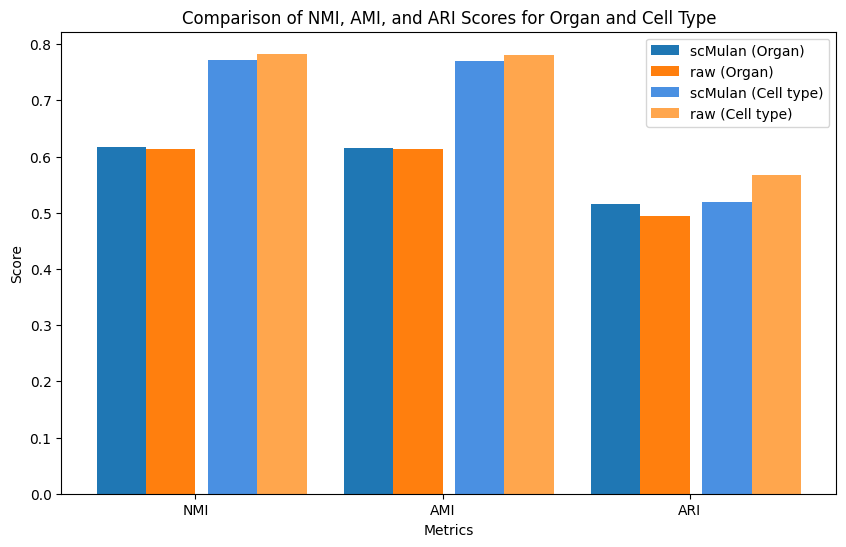

In [227]:
metrics = ['NMI', 'AMI', 'ARI']
organ_values = [0.617, 0.616, 0.516]
cell_type_values = [0.772, 0.770, 0.519]
organ_raw_values = [0.613, 0.613, 0.495]
cell_type_raw_values = [0.783, 0.781, 0.568]

# Set positions and width for bars
x = np.arange(len(metrics))  # the label locations for metrics
width = 0.2  # the width of the bars
small_gap = 0.05  # small gap between raw (Organ) and scMulan (Cell type)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Organ and Cell type for each metric
ax.bar(x - width, organ_values, width, label='scMulan (Organ)', color='#1f77b4')
ax.bar(x, organ_raw_values, width, label='raw (Organ)', color='#ff7f0e')
ax.bar(x + width + small_gap, cell_type_values, width, label='scMulan (Cell type)', color='#4a90e2')
ax.bar(x + 2 * width + small_gap, cell_type_raw_values, width, label='raw (Cell type)', color='#ffa64d')


# Adjust x-axis ticks to be centered between the groups of bars
tick_positions = x + width / 2  # Shift tick positions to the center of the four bars
ax.set_xticks(tick_positions)
ax.set_xticklabels(metrics)

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of NMI, AMI, and ARI Scores for Organ and Cell Type')
ax.legend()
plt.savefig("figures/Clustering_metrics.pdf")
plt.show()

##  6. Organ-specific performance

In [95]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,roc_curve, auc, confusion_matrix,roc_auc_score,r2_score, recall_score
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [68]:
def trans_name(name, map_dict):
    return map_dict[name]

In [241]:
def plot_confusion_matrix(confm, true_labels, all_labels, title, size=20, with_text=True, saving=None):
    """
    Plot a confusion matrix.

    Parameters:
    - confm: Original confusion matrix
    - true_labels: List of true labels
    - all_labels: List of all labels in the order they appear in confm
    - title: Title of the plot
    - size: Size of the plot
    - with_text: Whether to include text in the cells
    """
    plt.figure(figsize=(size, size))
    
    # Extract relevant rows based on true labels
    confm_selected = cm[[labels.index(lab) for lab in true_labels]]
    
    # Normalize
    confm_selected = confm_selected.astype('float') / (confm_selected.sum(axis=1)[:, np.newaxis] + 1e-9)
    confm_selected = np.around(confm_selected, 4)
    
    ax = plt.subplot(1, 1, 1)
    plt.imshow(confm_selected, interpolation='nearest', cmap='Blues')
    
    if with_text:
        for i in range(len(confm_selected)):
            for j in range(len(confm_selected[0])):
                color = 'w' if confm_selected[i, j] > 0.5 else 'black'
                plt.text(j, i, confm_selected[i, j], ha="center", va="center", color=color)
    
    plt.title(title)
    plt.xticks(np.arange(len(all_labels)), all_labels, rotation=90)
    plt.yticks(np.arange(len(true_labels)), true_labels, rotation=0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    if not (saving is None):
        plt.savefig(saving)
    plt.show()

In [90]:
import json

class uhaf_organ_trace:
    def __init__(self, organ_data):
        self.organ_data = organ_data

    def track_cell_from_organ(self, cell_type_target):
        trace = []
        def recursive_search(node, path):
            for key, value in node.items():
                new_path = path + [key]
                if key == cell_type_target:
                    return new_path
                if value:
                    found_path = recursive_search(value, new_path)
                    if found_path:
                        return found_path
            return None

        trace = recursive_search(self.organ_data, [])
        if trace:
            return trace
        else:
            raise ValueError(f"Cell type '{cell_type_target}' not found in the organ data")

    def get_MCT(self, cell_type_target, layer=1):
        trace = self.track_cell_from_organ(cell_type_target)
        assert len(trace) > layer
        return trace[layer]

    def is_ancestor(self, fine_ct, MCT):
        trace = self.track_cell_from_organ(fine_ct)
        return MCT in trace

def load_organs(file_path):
    with open(file_path, 'r') as file:
        organs = json.load(file)
    return organs

In [70]:
import json

class uhafOrganTrace:
    def __init__(self, uhaf_json_path, default_organ):
        self.organs_data = self.load_organs(uhaf_json_path)
        self.default_organ = default_organ

    def track_cell_from_organ(self, organ_data, cell_type_target):
        def recursive_search(node, path):
            for key, value in node.items():
                new_path = path + [key]
                if key == cell_type_target:
                    return new_path
                if value:
                    found_path = recursive_search(value, new_path)
                    if found_path:
                        return found_path
            return None

        trace = recursive_search(organ_data, [])
        if trace:
            return trace
        else:
            return None

    def get_MCT(self, cell_type_target, layer=1, global_search=False):
        if global_search:
            for organ_name, organ_data in self.organs_data.items():
                trace = self.track_cell_from_organ(organ_data, cell_type_target)
                if trace:
                    break
            if not trace:
                raise ValueError(f"Cell type '{cell_type_target}' not found in any organ data")
        else:
            organ_data = self.organs_data[self.default_organ]
            trace = self.track_cell_from_organ(organ_data, cell_type_target)
            if not trace:
                raise ValueError(f"Cell type '{cell_type_target}' not found in the organ data of {self.default_organ}")

        assert len(trace) > layer, f"Layer {layer} exceeds the depth of the trace"
        return trace[layer]

    def is_ancestor(self, fine_ct, MCT):
        for organ_name, organ_data in self.organs_data.items():
            trace = self.track_cell_from_organ(organ_data, fine_ct)
            if trace and MCT in trace:
                return True
        return False

    def load_organs(self,file_path):
        with open(file_path, 'r') as file:
            organs = json.load(file)
        return organs

### Lung

In [290]:
tissue = 'Lung'

In [291]:
adata_sub_organ = adata_mulan[(adata_mulan.obs['tissue'] == tissue ) & (adata_mulan.obs['cell_type'] != 'Unclassified')].copy()
adata_sub_organ

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5504 × 2000
    obs: 'celltype', 'n_genes', 'counts', 'cell_type_from_scMulan', 'cell_type_from_mulan_smoothing', 'smoothing_score', 'cell_type', 'tissue'
    uns: 'Smoothing', 'cell_type_colors', 'cell_type_from_mulan_smoothing_colors', 'cell_type_from_scMulan_colors', 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap', 'tissue_colors'
    obsm: 'X_pca', 'X_scMulan', 'X_umap'
    varm: 'PCs'
    obsp: 'Smoothing_connectivities', 'Smoothing_distances', 'connectivities', 'distances'

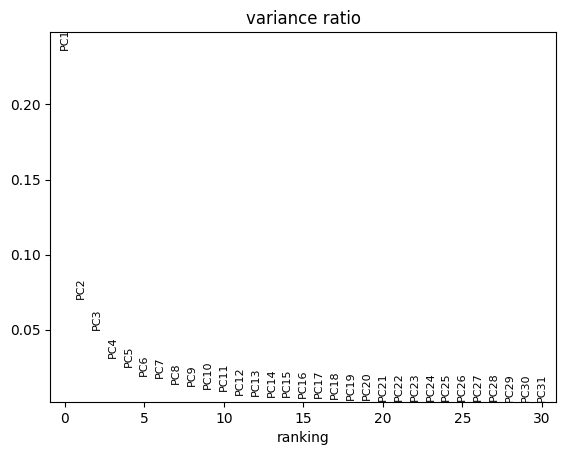

In [292]:
sc.pp.pca(adata_sub_organ)
sc.pl.pca_variance_ratio(adata_sub_organ)
sc.pp.neighbors(adata_sub_organ,n_pcs=12)
sc.tl.umap(adata_sub_organ)

In [107]:
adata_sub_organ.obs.cell_type.value_counts()

cell_type
stromal cell                                           2468
natural killer cell                                     797
lung endothelial cell                                   446
alveolar macrophage                                     329
T cell                                                  258
B cell                                                  217
non-classical monocyte                                  211
classical monocyte                                      156
leukocyte                                               149
myeloid cell                                             87
type II pneumocyte                                       84
nan                                                      57
ciliated columnar cell of tracheobronchial tree          56
basal cell of epidermis                                  37
mast cell                                                23
keratinocyte                                             21
hepatocyte                    

#### trans target to uhaf cell types

In [108]:
organ_name = 'Lung'

In [109]:
new_cts = adata_sub_organ.obs["cell_type"].unique().tolist()
print(new_cts)

['myeloid cell', 'bladder urothelial cell', 'B cell', 'natural killer cell', 'T cell', 'alveolar macrophage', 'lung endothelial cell', 'stromal cell', 'non-classical monocyte', 'leukocyte', 'basal cell of epidermis', 'classical monocyte', 'ciliated columnar cell of tracheobronchial tree', 'type II pneumocyte', 'hepatocyte', 'endothelial cell', 'nan', 'mast cell', 'kidney proximal straight tubule epithelial cell', 'mesenchymal stem cell', 'macrophage', 'immature T cell', 'luminal epithelial cell of mammary gland', 'kidney collecting duct epithelial cell', 'bladder cell', 'basal cell', 'monocyte', 'granulocyte', 'keratinocyte', 'kidney loop of Henle ascending limb epithelial cell', 'kidney capillary endothelial cell', 'fibroblast', 'granulocytopoietic cell']


In [110]:
prompt = f"My cell types in the {organ_name} are: \n {new_cts},\n Please map uHAF nodes for my cell types. Give me a json dict of the mapping nodes."
print(prompt)

My cell types in the Lung are: 
 ['myeloid cell', 'bladder urothelial cell', 'B cell', 'natural killer cell', 'T cell', 'alveolar macrophage', 'lung endothelial cell', 'stromal cell', 'non-classical monocyte', 'leukocyte', 'basal cell of epidermis', 'classical monocyte', 'ciliated columnar cell of tracheobronchial tree', 'type II pneumocyte', 'hepatocyte', 'endothelial cell', 'nan', 'mast cell', 'kidney proximal straight tubule epithelial cell', 'mesenchymal stem cell', 'macrophage', 'immature T cell', 'luminal epithelial cell of mammary gland', 'kidney collecting duct epithelial cell', 'bladder cell', 'basal cell', 'monocyte', 'granulocyte', 'keratinocyte', 'kidney loop of Henle ascending limb epithelial cell', 'kidney capillary endothelial cell', 'fibroblast', 'granulocytopoietic cell'],
 Please map uHAF nodes for my cell types. Give me a json dict of the mapping nodes.


In [293]:
cell_type_standard_organ = {
    "myeloid cell": "Myeloid cell",
    "bladder urothelial cell": "Unclassified",
    "B cell": "B cell",
    "natural killer cell": "NK cell",
    "T cell": "T cell",
    "alveolar macrophage": "Alveolar macrophage",
    "lung endothelial cell": "Endothelial cell",
    "stromal cell": "Stromal cell",
    "non-classical monocyte": "Non-classical monocyte",
    "leukocyte": "Lymphocyte",
    "basal cell of epidermis": "Basal cell",
    "classical monocyte": "Classical monocyte",
    "ciliated columnar cell of tracheobronchial tree": "Ciliated cell",
    "type II pneumocyte": "Type II alveolar cell",
    "Unclassified": "Unclassified",
    "hepatocyte": "Unclassified",
    "endothelial cell": "Endothelial cell",
    "nan": "Unclassified",
    "mast cell": "Mast cell",
    "kidney proximal straight tubule epithelial cell": "Unclassified",
    "mesenchymal stem cell": "Mesenchymal cell",
    "macrophage": "Macrophage",
    "immature T cell": "T cell",
    "luminal epithelial cell of mammary gland": "Unclassified",
    "kidney collecting duct epithelial cell": "Unclassified",
    "bladder cell": "Unclassified",
    "basal cell": "Basal cell",
    "monocyte": "Monocyte",
    "granulocyte": "Neutrophilic granulocyte",
    "keratinocyte": "Unclassified",
    "kidney loop of Henle ascending limb epithelial cell": "Unclassified",
    "kidney capillary endothelial cell": "Unclassified",
    "fibroblast": "Fibroblast",
    "granulocytopoietic cell": "Granulocyte-monocyte progenitor cell"
}

In [294]:
adata_sub_organ.obs['cell_type_trans'] = adata_sub_organ.obs['cell_type'].apply(trans_name, args=(cell_type_standard_organ,))

In [295]:
adata_sub_organ.obs['cell_type_trans'].value_counts()

cell_type_trans
Stromal cell                            2468
NK cell                                  797
Endothelial cell                         458
Alveolar macrophage                      329
T cell                                   269
B cell                                   217
Non-classical monocyte                   211
Classical monocyte                       156
Lymphocyte                               149
Unclassified                             139
Myeloid cell                              87
Type II alveolar cell                     84
Ciliated cell                             56
Basal cell                                42
Mast cell                                 23
Macrophage                                 7
Mesenchymal cell                           6
Fibroblast                                 3
Monocyte                                   1
Neutrophilic granulocyte                   1
Granulocyte-monocyte progenitor cell       1
Name: count, dtype: int64

In [296]:
adata_sub_organ.obs['cell_type_from_mulan_smoothing'].value_counts()

cell_type_from_mulan_smoothing
Basement membrane fibroblast           2469
Monocyte                                919
Memory CD8 T cell                       537
Vascular endothelial cell               459
NK cell                                 322
Memory B cell                           196
Pericyte                                160
CD4 Treg                                159
Cholangiocyte                           138
Naive CD8 T cell                         30
Plasmacytoid dendritic cell              20
Conventional dendritic cell 2            18
Smooth muscle cell                       13
Dendritic cell                           12
Hepatic stellate cell                     8
Naive B cell                              8
Capillary endothelial cell                7
Memory CD4 T cell                         5
Monocyte-dendritic progenitor (MDP)       4
Ciliated cell                             4
Vascular cell                             3
Fibroblast                                2
S

#### mapping dict from GPT

In [297]:
mapping_GPT = {
  "myeloid cell": "myeloid cell",
  "bladder urothelial cell": "bladder urothelial cell",
  "B cell": "B cell",
  "natural killer cell": "natural killer cell",
  "T cell": "T cell",
  "alveolar macrophage": "macrophage",
  "lung endothelial cell": "endothelial cell",
  "stromal cell": "stromal cell",
  "non-classical monocyte": "monocyte",
  "leukocyte": "leukocyte",
  "basal cell of epidermis": "basal cell",
  "classical monocyte": "monocyte",
  "ciliated columnar cell of tracheobronchial tree": "ciliated cell",
  "type II pneumocyte": "type II alveolar cell",
  "Unclassified": "Unclassified",
  "hepatocyte": "hepatocyte",
  "endothelial cell": "endothelial cell",
  "nan": "Unclassified",
  "mast cell": "mast cell",
  "kidney proximal straight tubule epithelial cell": "kidney epithelial cell",
  "mesenchymal stem cell": "stem cell",
  "macrophage": "macrophage",
  "immature T cell": "T cell",
  "luminal epithelial cell of mammary gland": "epithelial cell",
  "kidney collecting duct epithelial cell": "kidney epithelial cell",
  "bladder cell": "bladder cell",
  "basal cell": "basal cell",
  "monocyte": "monocyte",
  "granulocyte": "granulocyte",
  "keratinocyte": "keratinocyte",
  "kidney loop of Henle ascending limb epithelial cell": "kidney epithelial cell",
  "kidney capillary endothelial cell": "endothelial cell",
  "fibroblast": "stromal cell",
  "granulocytopoietic cell": "granulocyte",
  "Plasmacytoid dendritic cell": "dendritic cell",
  "Memory B cell": "B cell",
  "Memory CD8 T cell": "T cell",
  "Vascular endothelial cell": "endothelial cell",
  "Basement membrane fibroblast": "stromal cell",
  "NK cell": "natural killer cell",
  "CD4 Treg": "T cell",
  "Conventional dendritic cell 2": "dendritic cell",
  "Cholangiocyte": "epithelial cell",
  "Hepatic stellate cell": "hepatocyte",
  "Pericyte": "stromal cell",
  "Capillary endothelial cell": "endothelial cell",
  "Naive B cell": "B cell",
  "Smooth muscle cell": "muscle cell",
  "Cardiomyocyte cell": "muscle cell",
  "Vascular cell": "endothelial cell",
  "Monocyte-dendritic progenitor (MDP)": "progenitor cell",
  "Macrophage": "macrophage",
  "Ciliated cell": "ciliated cell",
  "Multipotent progenitor (MPP)": "stem cell",
  "Fibroblast": "stromal cell",
  "Type II alveolar cell": "type II alveolar cell",
  "Granulocyte": "granulocyte",
  "Memory CD4 T cell": "T cell",
  "Secretory cell": "epithelial cell",
  "Dendritic cell": "dendritic cell",
  "Naive CD8 T cell": "T cell",
  "Kupffer cell": "macrophage",
  "Proliferating cell": "progenitor cell",
  "Erythroid-like cell": "erythroid cell",
  "Microglia": "microglia",
  "Monocyte": "monocyte",
    
}


In [298]:
GPT_MCT = {
  "myeloid cell": "immune cell",
  "bladder urothelial cell": "epithelial cell",
  "B cell": "immune cell",
  "natural killer cell": "immune cell",
  "T cell": "immune cell",
  "alveolar macrophage": "immune cell",
  "lung endothelial cell": "endothelial cell",
  "stromal cell": "stromal cell",
  "non-classical monocyte": "immune cell",
  "leukocyte": "immune cell",
  "basal cell of epidermis": "epithelial cell",
  "classical monocyte": "immune cell",
  "ciliated columnar cell of tracheobronchial tree": "epithelial cell",
  "type II pneumocyte": "epithelial cell",
  "Unclassified": "Unclassified",
  "hepatocyte": "epithelial cell",
  "endothelial cell": "endothelial cell",
  "nan": "Unclassified",
  "mast cell": "immune cell",
  "kidney proximal straight tubule epithelial cell": "epithelial cell",
  "mesenchymal stem cell": "stem cell",
  "macrophage": "immune cell",
  "immature T cell": "immune cell",
  "luminal epithelial cell of mammary gland": "epithelial cell",
  "kidney collecting duct epithelial cell": "epithelial cell",
  "bladder cell": "epithelial cell",
  "basal cell": "epithelial cell",
  "monocyte": "immune cell",
  'Monocyte':"immune cell",
  "granulocyte": "immune cell",
  "keratinocyte": "epithelial cell",
  "kidney loop of Henle ascending limb epithelial cell": "epithelial cell",
  "kidney capillary endothelial cell": "endothelial cell",
  "fibroblast": "stromal cell",
  "granulocytopoietic cell": "immune cell",
  "Plasmacytoid dendritic cell": "immune cell",
  "Memory B cell": "immune cell",
  "Memory CD8 T cell": "immune cell",
  "Vascular endothelial cell": "endothelial cell",
  "Basement membrane fibroblast": "stromal cell",
  "NK cell": "immune cell",
  "CD4 Treg": "immune cell",
  "Conventional dendritic cell 2": "immune cell",
  "Cholangiocyte": "epithelial cell",
  "Hepatic stellate cell": "epithelial cell",
  "Pericyte": "stromal cell",
  "Capillary endothelial cell": "endothelial cell",
  "Naive B cell": "immune cell",
  "Smooth muscle cell": "muscle cell",
  "Cardiomyocyte cell": "muscle cell",
  "Vascular cell": "endothelial cell",
  "Monocyte-dendritic progenitor (MDP)": "stem cell",
  "Macrophage": "immune cell",
  "Ciliated cell": "epithelial cell",
  "Multipotent progenitor (MPP)": "stem cell",
  "Fibroblast": "stromal cell",
  "Type II alveolar cell": "epithelial cell",
  "Granulocyte": "immune cell",
  "Memory CD4 T cell": "immune cell",
  "Secretory cell": "epithelial cell",
  "Dendritic cell": "immune cell",
  "Naive CD8 T cell": "immune cell",
  "Kupffer cell": "immune cell",
  "Proliferating cell": "stem cell",
  "Erythroid-like cell": "blood cell",
  "Microglia": "immune cell"
}


In [299]:
adata_sub_organ.obs['cell_type_GPT'] = adata_sub_organ.obs['cell_type'].apply(trans_name, args=(mapping_GPT,))
adata_sub_organ.obs['scmulan_GPT'] = adata_sub_organ.obs['cell_type_from_mulan_smoothing'].apply(trans_name, args=(mapping_GPT,))

In [300]:
adata_sub_organ.obs['cell_type_MCT_GPT'] = adata_sub_organ.obs['cell_type'].apply(trans_name, args=(GPT_MCT,))
adata_sub_organ.obs['scmulan_MCT_GPT'] = adata_sub_organ.obs['cell_type_from_mulan_smoothing'].apply(trans_name, args=(GPT_MCT,))

In [132]:
import colorcet as cc

/tmp/ipykernel_945746/3155327062.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", len(unique_labels))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plo

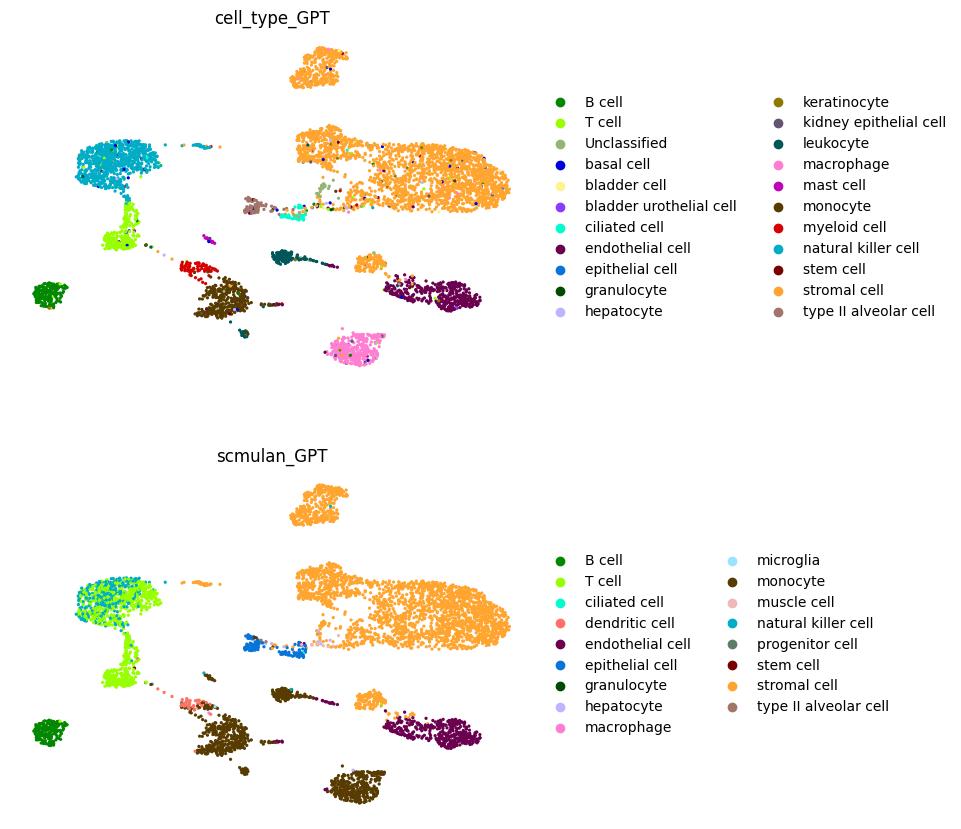

In [131]:
# unified colors of cell types
unique_labels = pd.concat([adata_sub_organ.obs["cell_type_GPT"], adata_sub_organ.obs["scmulan_GPT"]]).unique()
colors = plt.cm.get_cmap("hsv", len(unique_labels))
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

colors = cc.glasbey[:len(unique_labels)]
color_map = dict(zip(unique_labels, colors))

adata_sub_organ.obs["cell_type_GPT_colors"] = adata_sub_organ.obs["cell_type_GPT"].map(color_map)
adata_sub_organ.obs["scmulan_GPT_colors"] = adata_sub_organ.obs["scmulan_GPT"].map(color_map)

# draw umap
sc.pl.umap(adata_sub_organ,color=["cell_type_GPT","scmulan_GPT"], palette=color_map, ncols=1, frameon=False,save="_TM_cell_type_Lung.pdf")

/tmp/ipykernel_945746/1239393350.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", len(unique_labels))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plo

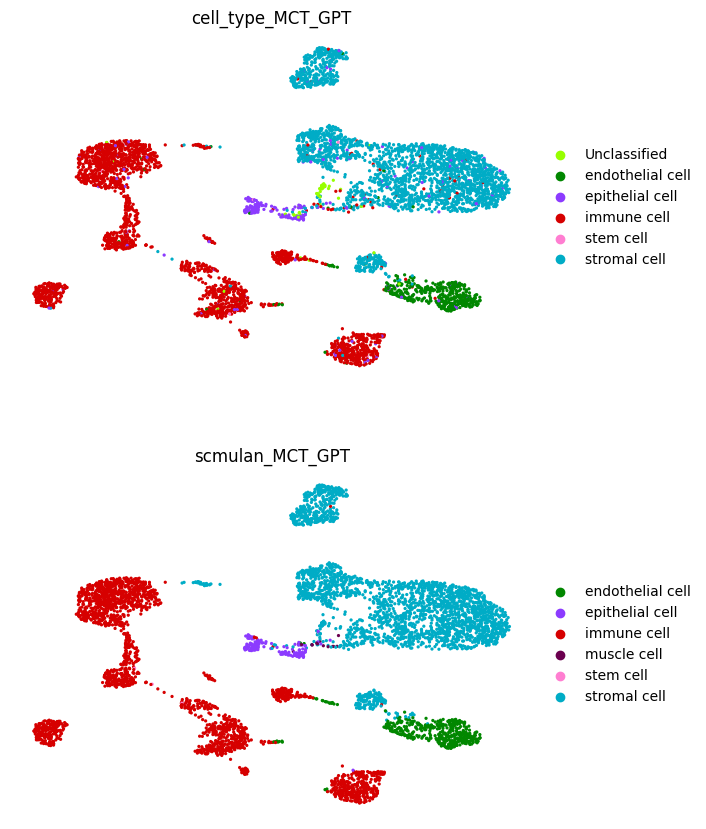

In [133]:
# unified colors of cell types
unique_labels = pd.concat([adata_sub_organ.obs["cell_type_MCT_GPT"], adata_sub_organ.obs["scmulan_MCT_GPT"]]).unique()
colors = plt.cm.get_cmap("hsv", len(unique_labels))
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

colors = cc.glasbey[:len(unique_labels)]
color_map = dict(zip(unique_labels, colors))

adata_sub_organ.obs["cell_type_MCT_GPT_colors"] = adata_sub_organ.obs["cell_type_GPT"].map(color_map)
adata_sub_organ.obs["scmulan_MCT_GPT_colors"] = adata_sub_organ.obs["scmulan_MCT_GPT"].map(color_map)

# draw umap
sc.pl.umap(adata_sub_organ,color=["cell_type_MCT_GPT","scmulan_MCT_GPT"], palette=color_map, ncols=1, frameon=False,save="_TM_MCT_Lung.pdf")

In [301]:
targets_ = adata_sub_organ.obs['cell_type_GPT'].tolist()
preds_ = adata_sub_organ.obs['scmulan_GPT'].tolist()

In [302]:
labels = list(Counter(targets_ + preds_).keys())
true_labels = list(Counter(targets_).keys())

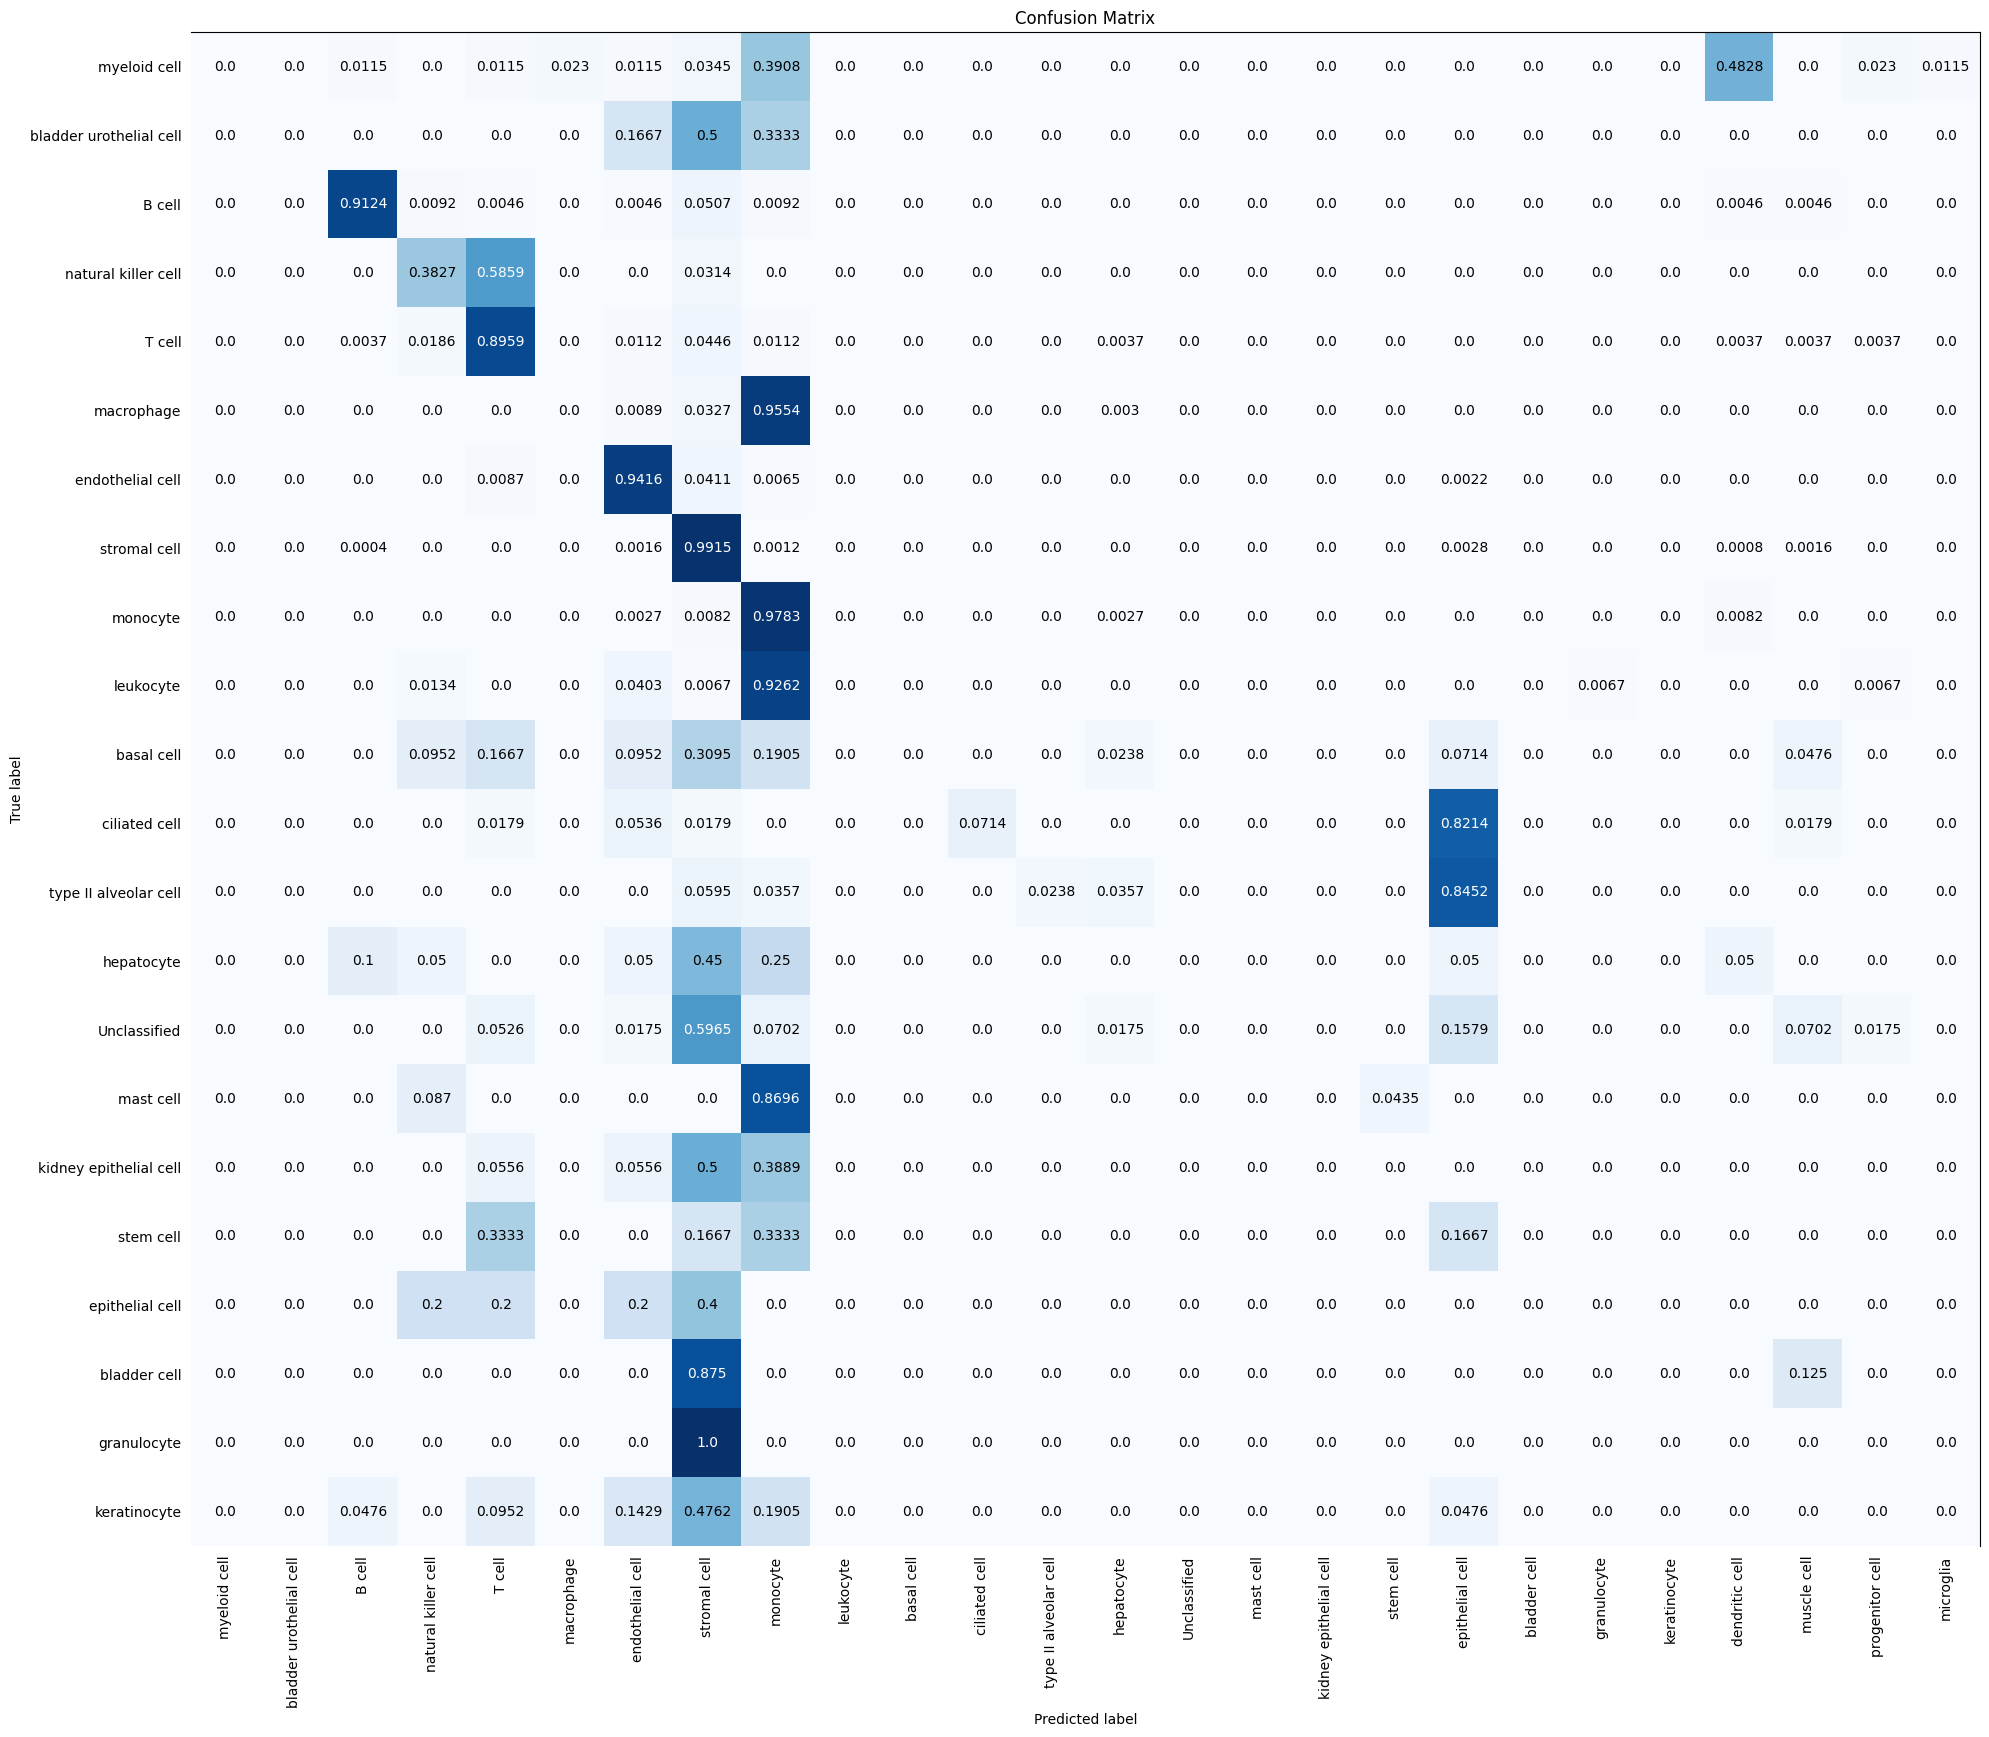

In [303]:
cm = confusion_matrix(targets_, preds_, labels=labels)
pd.DataFrame(cm[[labels.index(lab) for lab in true_labels]], index=true_labels, columns=labels).to_csv("TM_cross_species/CM.cell_type.Lung.csv")
plot_confusion_matrix(cm, true_labels, labels, "Confusion Matrix", saving="figures/ConfusionMatrix_celltype_Lung.pdf")

In [141]:
accuracy = accuracy_score(targets_, preds_)
recall = recall_score(targets_, preds_, average='weighted')
f1 = f1_score(targets_, preds_, average='weighted')

accuracy, recall, f1

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7258357558139535, 0.7258357558139535, 0.6886600231522291)

In [304]:
targets_ = adata_sub_organ.obs['cell_type_MCT_GPT'].tolist()
preds_ = adata_sub_organ.obs['scmulan_MCT_GPT'].tolist()

In [305]:
labels = list(Counter(targets_ + preds_).keys())
true_labels = list(Counter(targets_).keys())

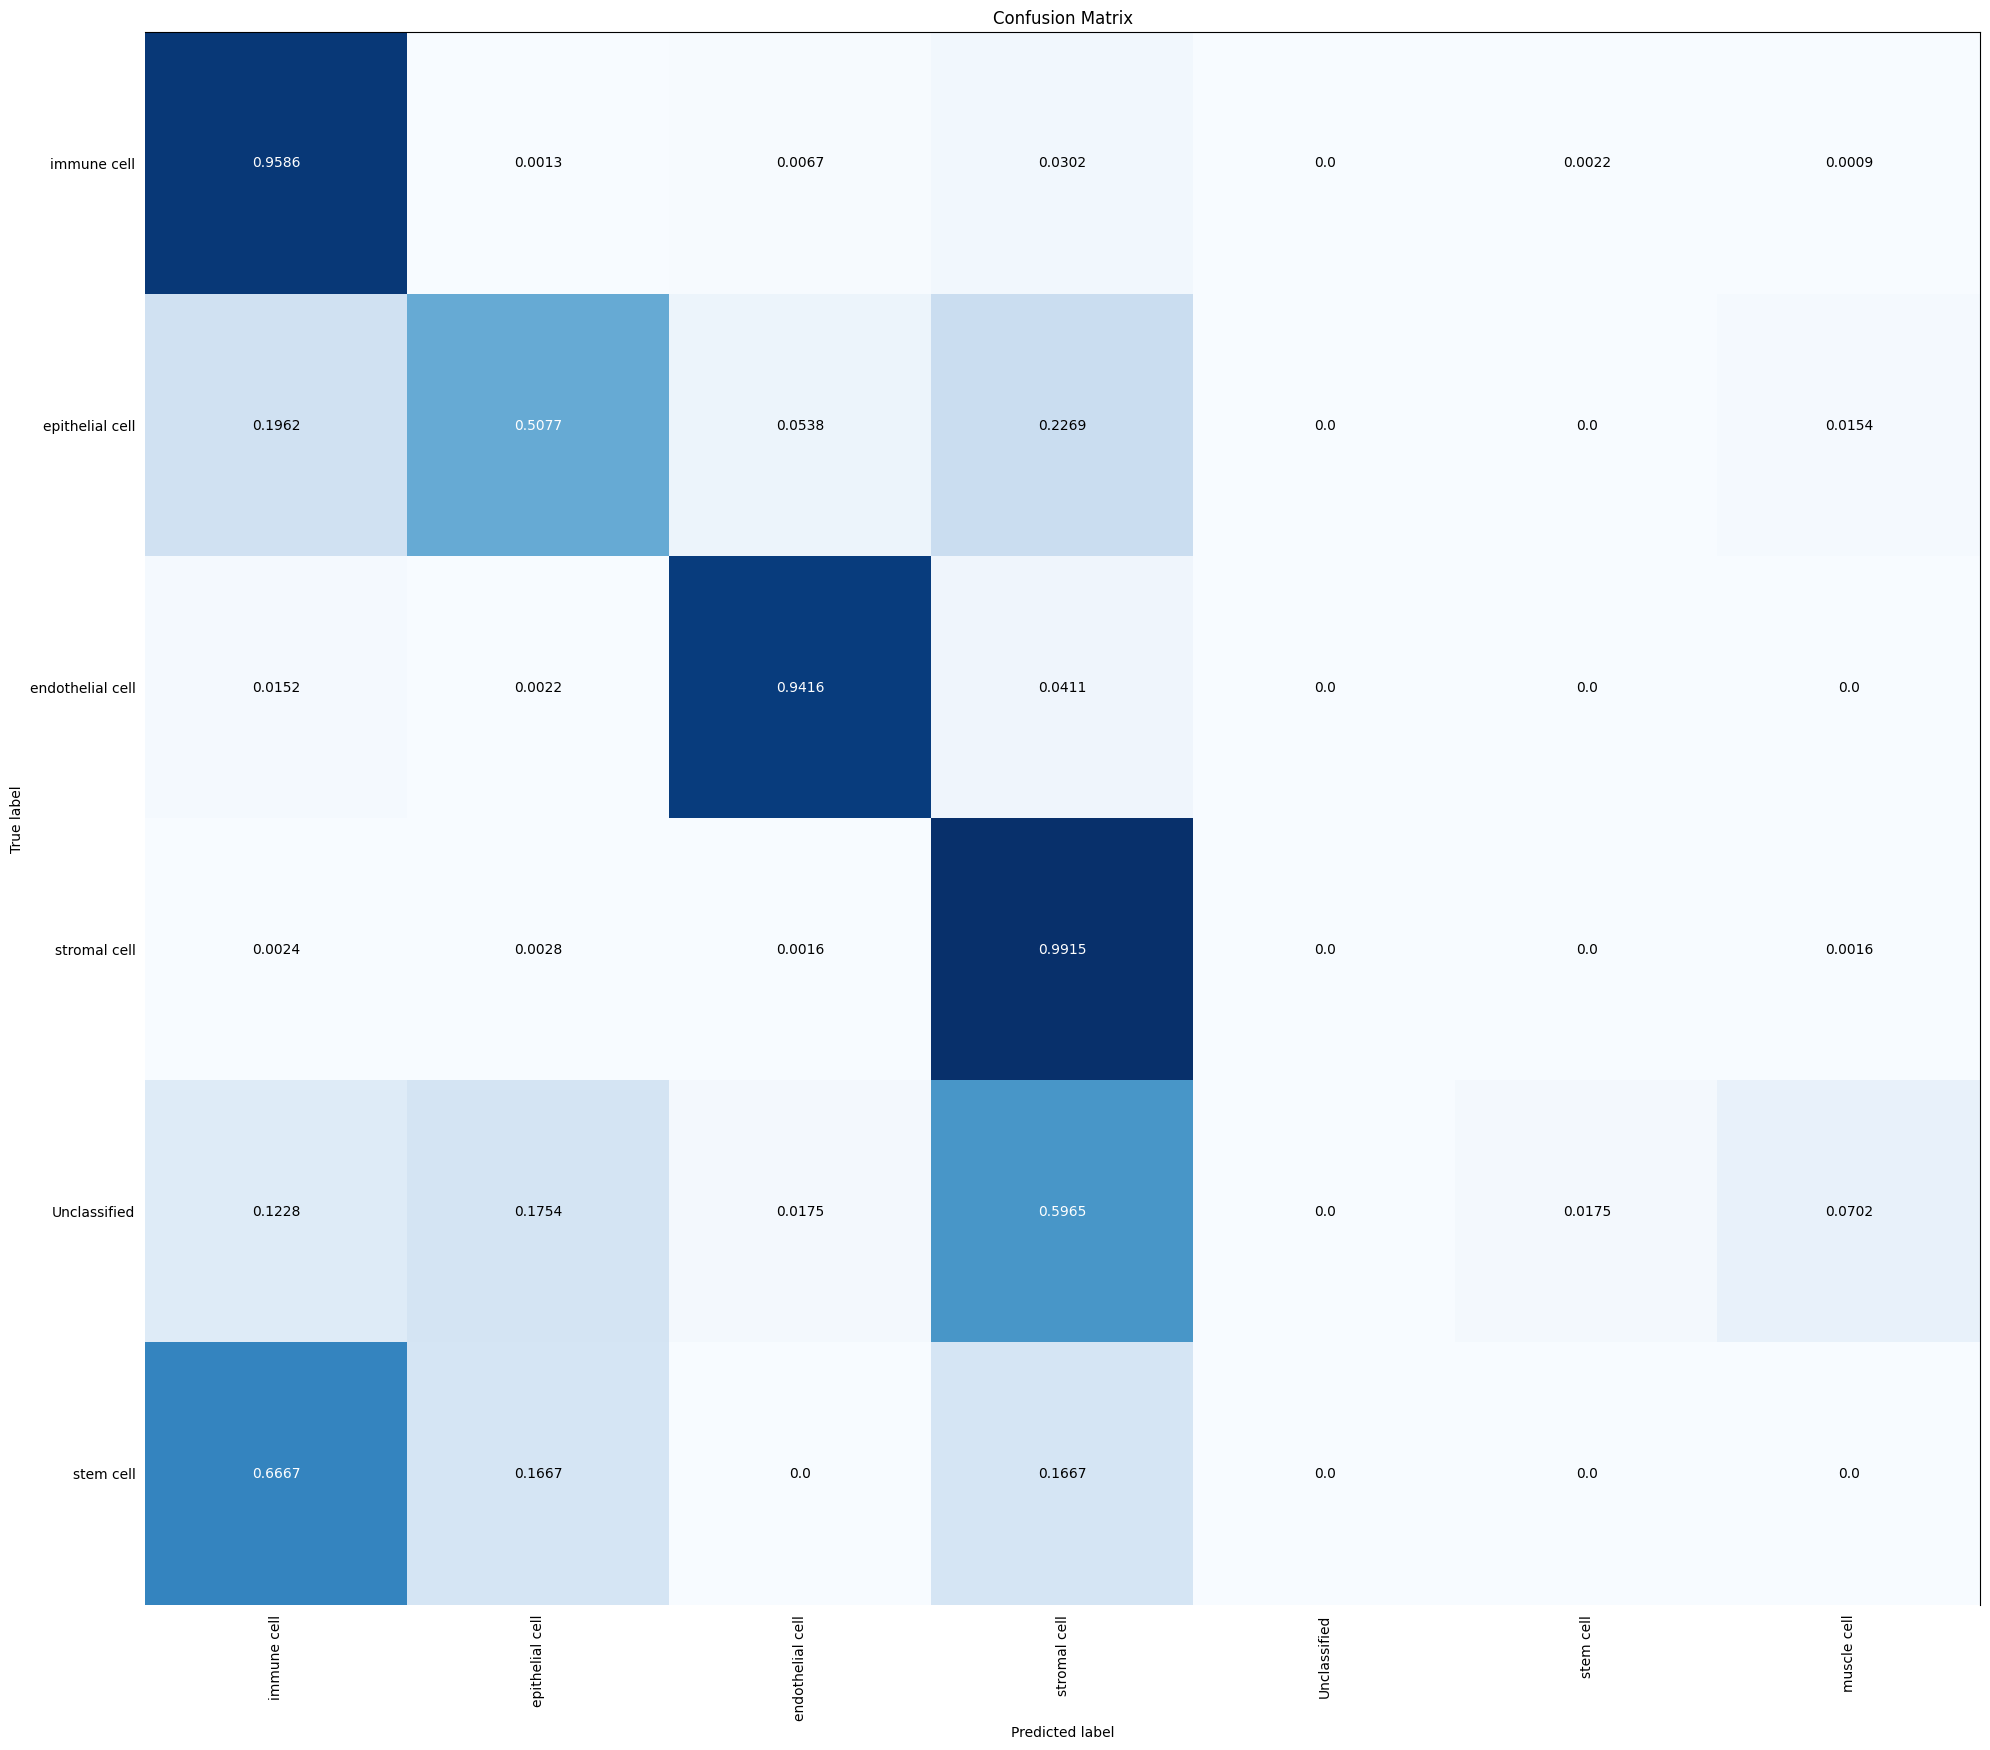

In [306]:
cm = confusion_matrix(targets_, preds_, labels=labels)
pd.DataFrame(cm[[labels.index(lab) for lab in true_labels]], index=true_labels, columns=labels).to_csv("TM_cross_species/CM.MCT.Lung.csv")
plot_confusion_matrix(cm, true_labels, labels, "Confusion Matrix", saving="figures/ConfusionMatrix_MCT_Lung.pdf")

In [145]:
accuracy = accuracy_score(targets_, preds_)
recall = recall_score(targets_, preds_, average='weighted')
f1 = f1_score(targets_, preds_, average='weighted')

accuracy, recall, f1

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9396802325581395, 0.9396802325581395, 0.9328408719766883)

### Liver

In [307]:
tissue = 'Liver'

In [308]:
adata_sub_organ = adata_mulan[(adata_mulan.obs['tissue'] == tissue ) & (adata_mulan.obs['cell_type'] != 'Unclassified')].copy()

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


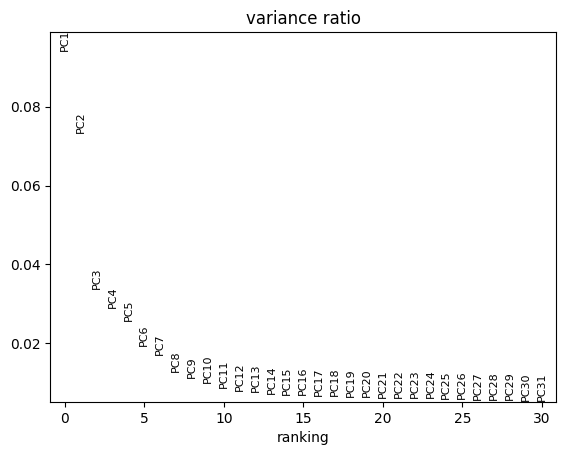

In [309]:
sc.pp.pca(adata_sub_organ)
sc.pl.pca_variance_ratio(adata_sub_organ)
sc.pp.neighbors(adata_sub_organ,n_pcs=15)
sc.tl.umap(adata_sub_organ)

In [310]:
adata_sub_organ.obs.cell_type.value_counts()

cell_type
hepatocyte                                         1765
endothelial cell of hepatic sinusoid                 28
duct epithelial cell                                 27
leukocyte                                            26
immature T cell                                       3
myeloid cell                                          2
bladder urothelial cell                               1
B cell                                                1
ciliated columnar cell of tracheobronchial tree       1
cardiac muscle cell                                   1
stromal cell                                          1
type II pneumocyte                                    1
Name: count, dtype: int64

#### trans target to uhaf cell types

In [275]:
organ_name = 'Liver'

In [150]:
new_cts = adata_sub_organ.obs["cell_type"].unique().tolist()
print(new_cts)

['hepatocyte', 'endothelial cell of hepatic sinusoid', 'myeloid cell', 'ciliated columnar cell of tracheobronchial tree', 'leukocyte', 'type II pneumocyte', 'bladder urothelial cell', 'stromal cell', 'immature T cell', 'B cell', 'duct epithelial cell', 'cardiac muscle cell']


In [283]:
prompt = f"My cell types in the {organ_name} are: \n {new_cts},\n Please map uHAF nodes for my cell types. Give me a json dict of the mapping nodes."
print(prompt)

My cell types in the Lung are: 
 ['myeloid cell', 'bladder urothelial cell', 'B cell', 'natural killer cell', 'T cell', 'alveolar macrophage', 'lung endothelial cell', 'stromal cell', 'non-classical monocyte', 'leukocyte', 'basal cell of epidermis', 'classical monocyte', 'ciliated columnar cell of tracheobronchial tree', 'type II pneumocyte', 'hepatocyte', 'endothelial cell', 'nan', 'mast cell', 'kidney proximal straight tubule epithelial cell', 'mesenchymal stem cell', 'macrophage', 'immature T cell', 'luminal epithelial cell of mammary gland', 'kidney collecting duct epithelial cell', 'bladder cell', 'basal cell', 'monocyte', 'granulocyte', 'keratinocyte', 'kidney loop of Henle ascending limb epithelial cell', 'kidney capillary endothelial cell', 'fibroblast', 'granulocytopoietic cell'],
 Please map uHAF nodes for my cell types. Give me a json dict of the mapping nodes.


In [311]:
print(adata_sub_organ.obs['cell_type_from_mulan_smoothing'].unique().tolist())

['Hepatocyte', 'Sinusoidal endothelial cell', 'Monocyte', 'Cholangiocyte', 'Kupffer cell', 'Dendritic cell', 'Basement membrane fibroblast', 'CD4 Treg', 'Memory CD8 T cell']


In [328]:
print(adata_sub_organ.obs['cell_type_from_scMulan'].unique().tolist())

['Hepatocyte', 'Sinusoidal endothelial cell', 'Monocyte', 'Cholangiocyte', 'Kupffer cell', 'Hepatic stellate cell', 'CD4 Treg']


#### mapping dict from GPT

In [279]:
mapping_GPT = {
  "hepatocyte": "Hepatocyte",
  "endothelial cell of hepatic sinusoid": "Endothelial cell",
  "myeloid cell": "Myeloid cell",
  "ciliated columnar cell of tracheobronchial tree": "Ciliated cell",
  "leukocyte": "Leukocyte",
  "type II pneumocyte": "Type II pneumocyte",
  "bladder urothelial cell": "Bladder urothelial cell",
  "stromal cell": "Stromal cell",
  "immature T cell": "T cell",
  "B cell": "B cell",
  "duct epithelial cell": "Duct epithelial cell",
  "cardiac muscle cell": "Cardiac muscle cell",
  "Hepatocyte": "Hepatocyte",
  "Sinusoidal endothelial cell": "Endothelial cell",
  "Monocyte": "Myeloid cell",
  "Cholangiocyte": "Bladder urothelial cell",
  "Kupffer cell": "Myeloid cell",
  "Dendritic cell": "Myeloid cell",
  "Basement membrane fibroblast": "Stromal cell",
  "CD4 Treg": "T cell",
  "Memory CD8 T cell": "T cell"
}



In [280]:
GPT_MCT = {
  "hepatocyte": "epithelial cell",
  "endothelial cell of hepatic sinusoid": "endothelial cell",
  "myeloid cell": "immune cell",
  "ciliated columnar cell of tracheobronchial tree": "epithelial cell",
  "leukocyte": "immune cell",
  "type II pneumocyte": "epithelial cell",
  "bladder urothelial cell": "epithelial cell",
  "stromal cell": "stromal cell",
  "immature T cell": "immune cell",
  "B cell": "immune cell",
  "duct epithelial cell": "epithelial cell",
  "cardiac muscle cell": "muscle cell",
  "Hepatocyte": "epithelial cell",
  "Sinusoidal endothelial cell": "endothelial cell",
  "Monocyte": "immune cell",
  "Cholangiocyte": "epithelial cell",
  "Kupffer cell": "immune cell",
  "Dendritic cell": "immune cell",
  "Basement membrane fibroblast": "stromal cell",
  "CD4 Treg": "immune cell",
  "Memory CD8 T cell": "immune cell"
}


In [281]:
adata_sub_organ.obs['cell_type_GPT'] = adata_sub_organ.obs['cell_type'].apply(trans_name, args=(mapping_GPT,))
adata_sub_organ.obs['scmulan_GPT'] = adata_sub_organ.obs['cell_type_from_mulan_smoothing'].apply(trans_name, args=(mapping_GPT,))

In [282]:
adata_sub_organ.obs['cell_type_MCT_GPT'] = adata_sub_organ.obs['cell_type'].apply(trans_name, args=(GPT_MCT,))
adata_sub_organ.obs['scmulan_MCT_GPT'] = adata_sub_organ.obs['cell_type_from_mulan_smoothing'].apply(trans_name, args=(GPT_MCT,))

/tmp/ipykernel_945746/2419888679.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", len(unique_labels))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plo

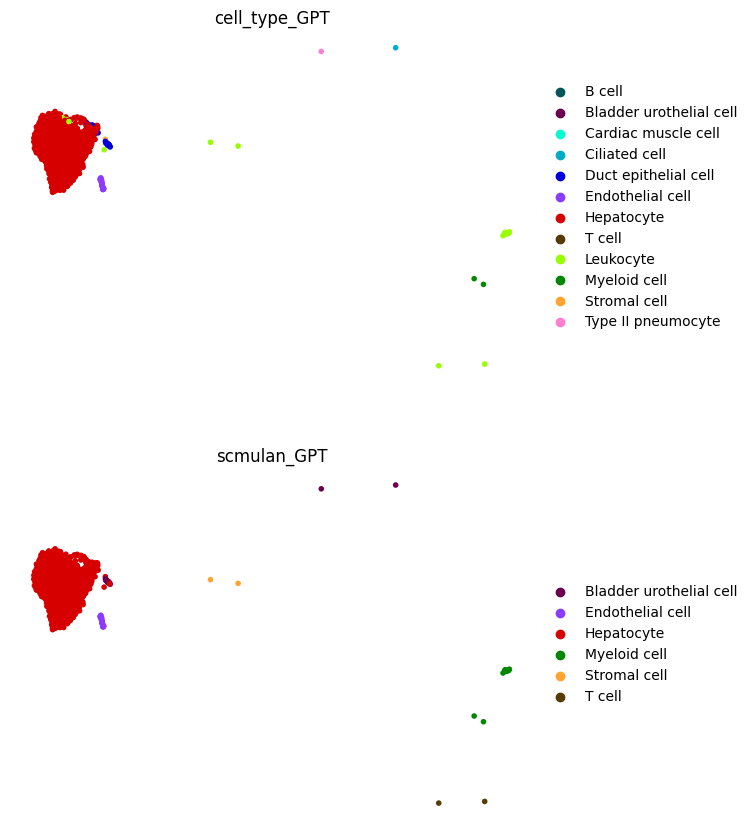

In [155]:
# unified colors of cell types
unique_labels = pd.concat([adata_sub_organ.obs["cell_type_GPT"], adata_sub_organ.obs["scmulan_GPT"]]).unique()
colors = plt.cm.get_cmap("hsv", len(unique_labels))
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

colors = cc.glasbey[:len(unique_labels)]
color_map = dict(zip(unique_labels, colors))

adata_sub_organ.obs["cell_type_GPT_colors"] = adata_sub_organ.obs["cell_type_GPT"].map(color_map)
adata_sub_organ.obs["scmulan_GPT_colors"] = adata_sub_organ.obs["scmulan_GPT"].map(color_map)

# draw umap
sc.pl.umap(adata_sub_organ,color=["cell_type_GPT","scmulan_GPT"], palette=color_map, ncols=1, frameon=False,save="_TM_cell_type_Liver.pdf")

/tmp/ipykernel_945746/2464196968.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", len(unique_labels))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plo

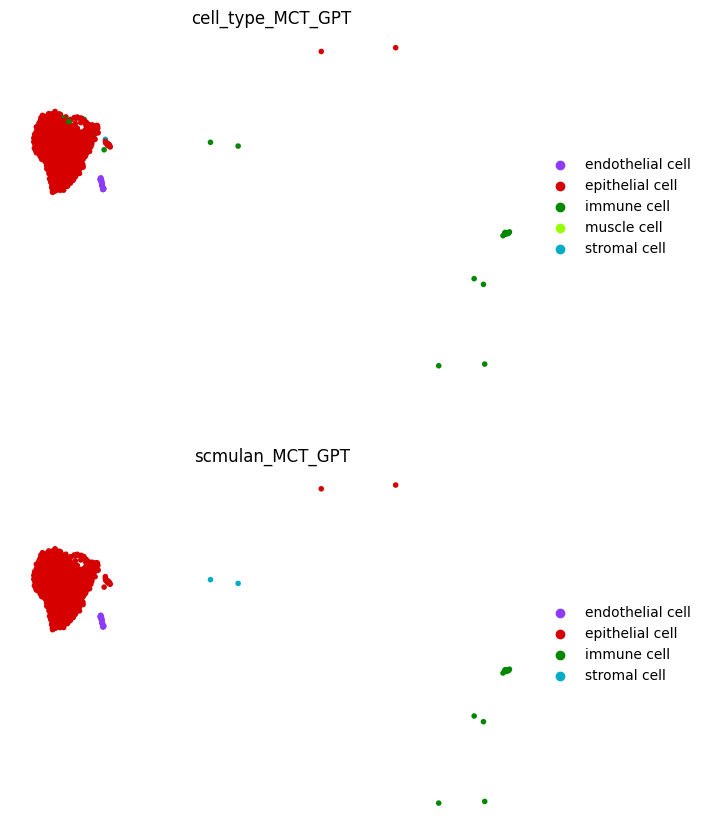

In [156]:
# unified colors of cell types
unique_labels = pd.concat([adata_sub_organ.obs["cell_type_MCT_GPT"], adata_sub_organ.obs["scmulan_MCT_GPT"]]).unique()
colors = plt.cm.get_cmap("hsv", len(unique_labels))
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

colors = cc.glasbey[:len(unique_labels)]
color_map = dict(zip(unique_labels, colors))

adata_sub_organ.obs["cell_type_MCT_GPT_colors"] = adata_sub_organ.obs["cell_type_GPT"].map(color_map)
adata_sub_organ.obs["scmulan_MCT_GPT_colors"] = adata_sub_organ.obs["scmulan_MCT_GPT"].map(color_map)

# draw umap
sc.pl.umap(adata_sub_organ,color=["cell_type_MCT_GPT","scmulan_MCT_GPT"], palette=color_map, ncols=1, frameon=False,save="_TM_MCT_Liver.pdf")

In [283]:
targets_ = adata_sub_organ.obs['cell_type_GPT'].tolist()
preds_ = adata_sub_organ.obs['scmulan_GPT'].tolist()

In [284]:
labels = list(Counter(targets_ + preds_).keys())
true_labels = list(Counter(targets_).keys())

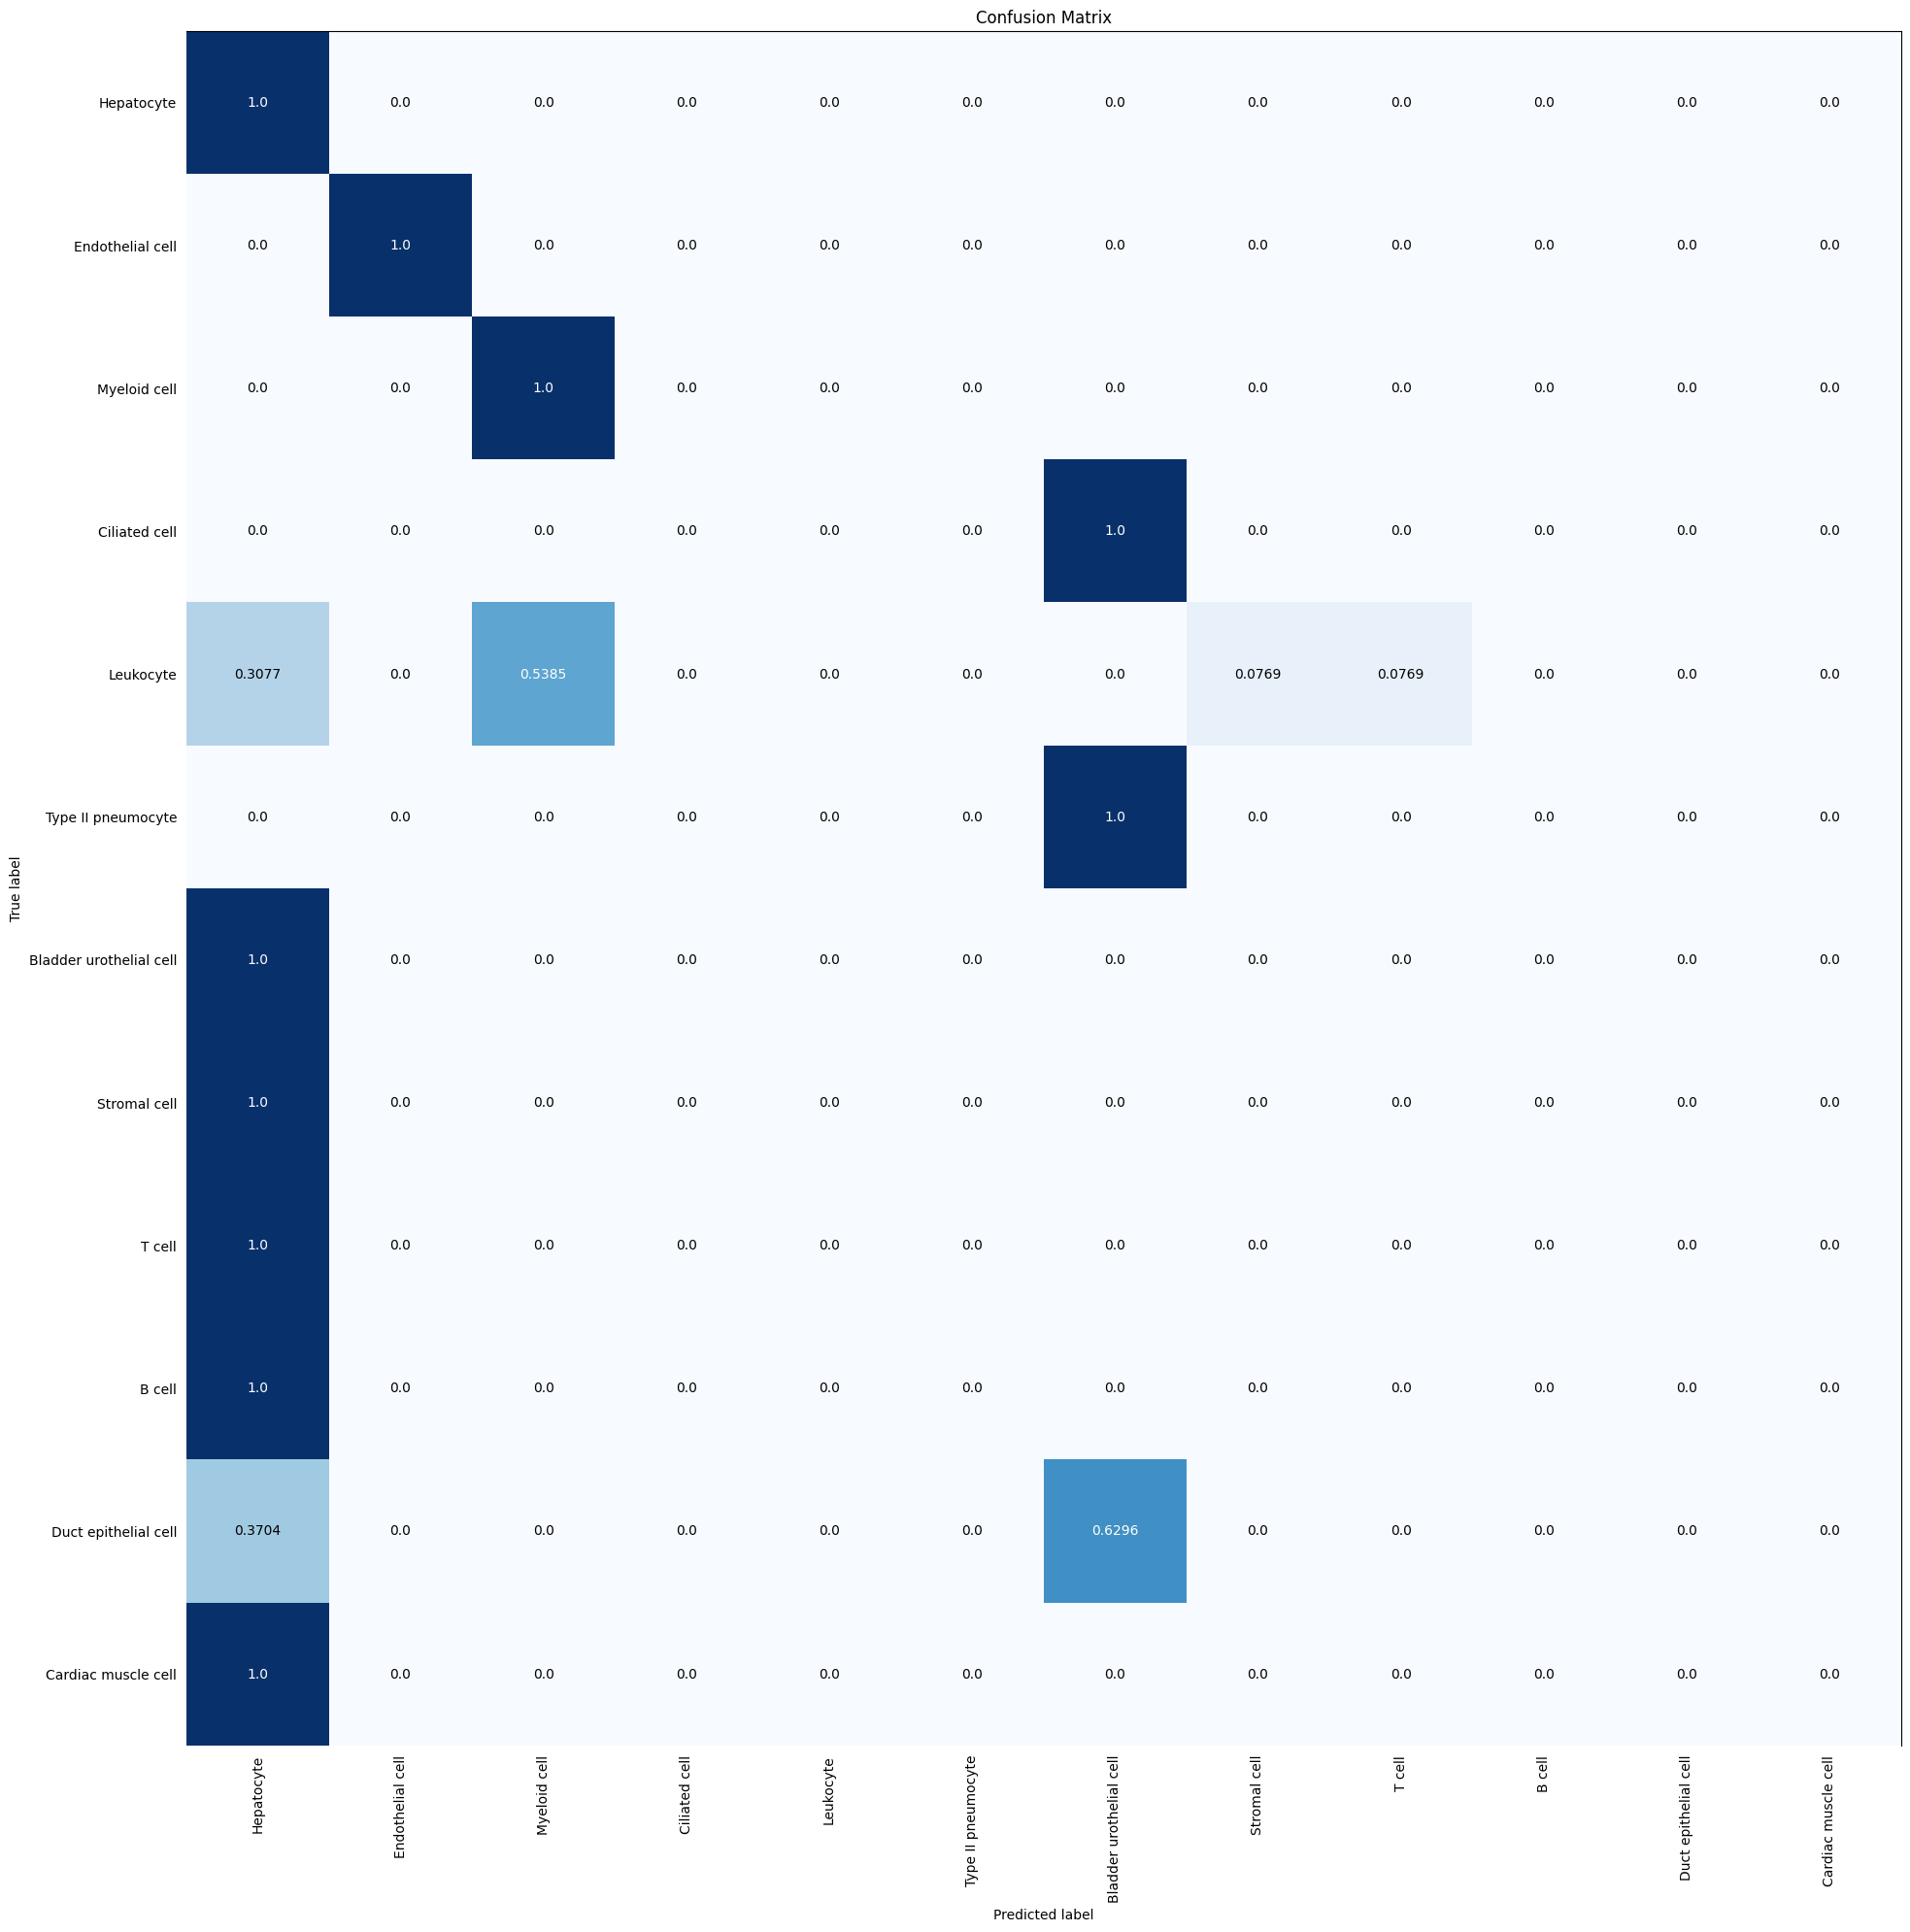

In [285]:
cm = confusion_matrix(targets_, preds_, labels=labels)
pd.DataFrame(cm[[labels.index(lab) for lab in true_labels]], index=true_labels, columns=labels).to_csv("TM_cross_species/CM.cell_type.Liver.csv")
plot_confusion_matrix(cm, true_labels, labels, "Confusion Matrix",saving="figures/ConfusionMatrix_celltype_Liver.pdf")

In [161]:
accuracy = accuracy_score(targets_, preds_)
recall = recall_score(targets_, preds_, average='weighted')
f1 = f1_score(targets_, preds_, average='weighted')

accuracy, recall, f1

(0.96661281637049, 0.96661281637049, 0.9590911948327953)

In [287]:
targets_ = adata_sub_organ.obs['cell_type_MCT_GPT'].tolist()
preds_ = adata_sub_organ.obs['scmulan_MCT_GPT'].tolist()

In [288]:
labels = list(Counter(targets_ + preds_).keys())
true_labels = list(Counter(targets_).keys())

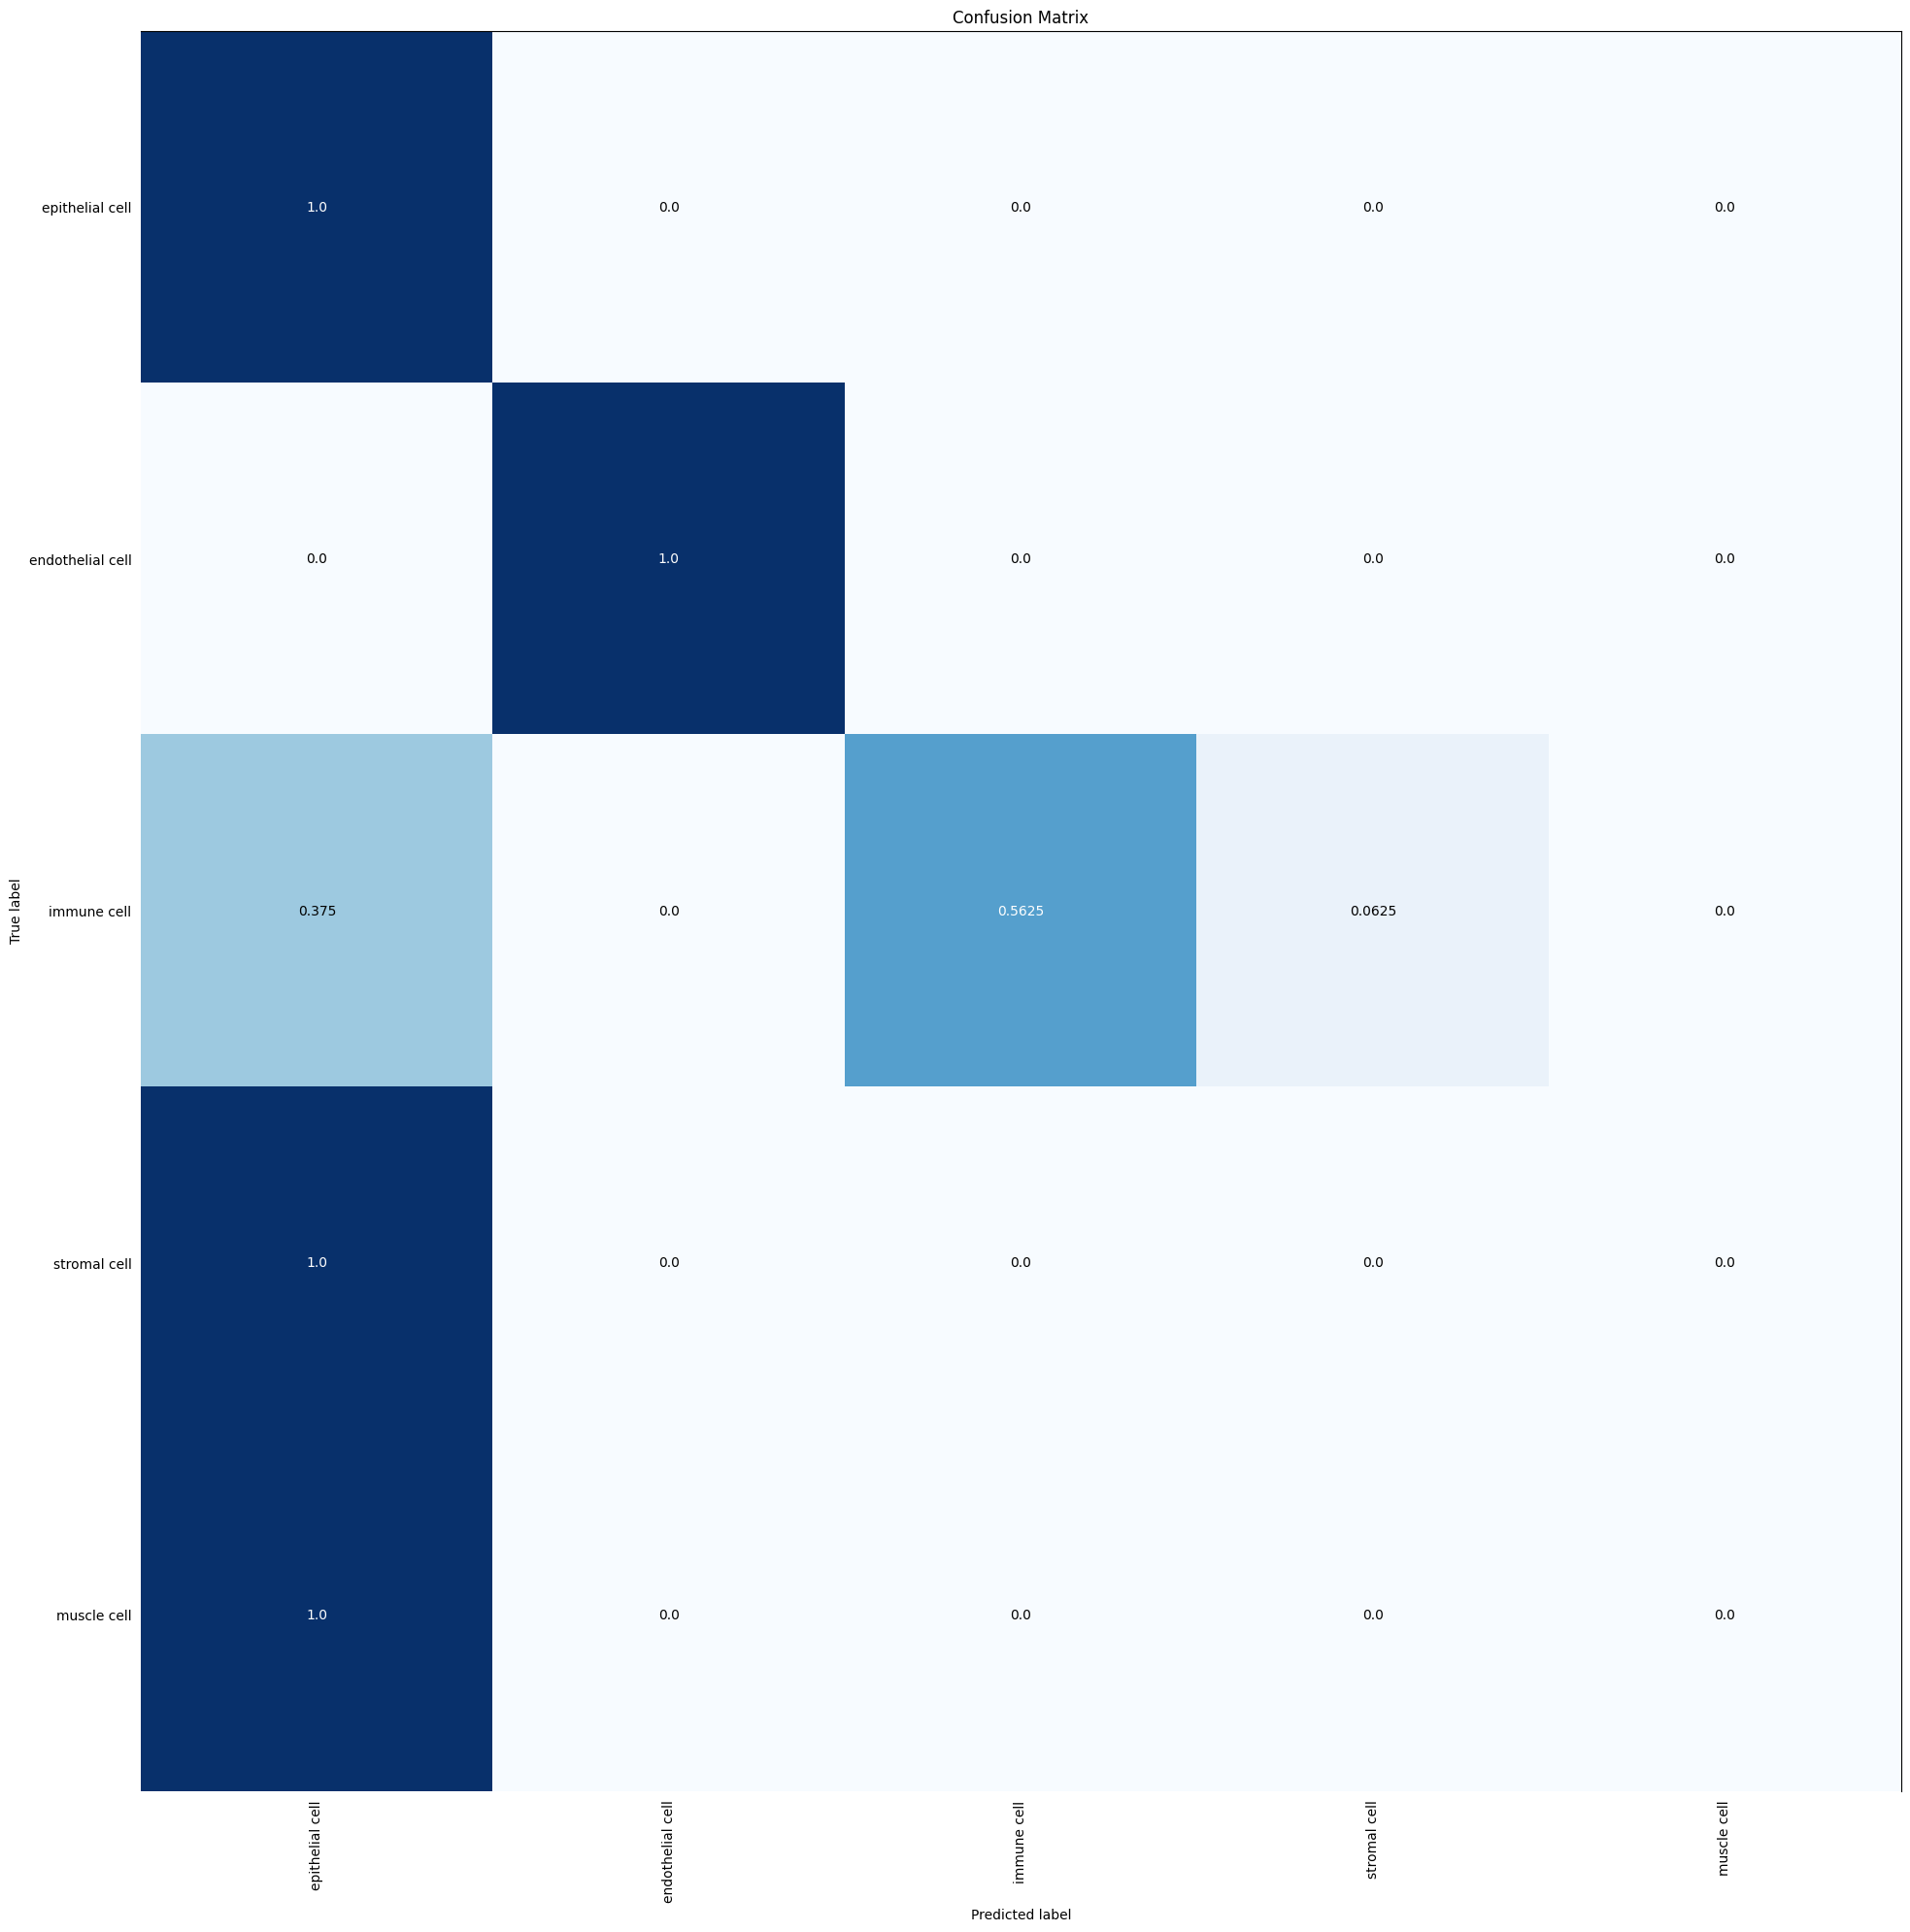

In [289]:
cm = confusion_matrix(targets_, preds_, labels=labels)
pd.DataFrame(cm[[labels.index(lab) for lab in true_labels]], index=true_labels, columns=labels).to_csv("TM_cross_species/CM.MCT.Liver.csv")
plot_confusion_matrix(cm, true_labels, labels, "Confusion Matrix",saving="figures/ConfusionMatrix_MCT_Liver.pdf")

In [166]:
accuracy = accuracy_score(targets_, preds_)
recall = recall_score(targets_, preds_, average='weighted')
f1 = f1_score(targets_, preds_, average='weighted')

accuracy, recall, f1

(0.9913839526117394, 0.9913839526117394, 0.9903431297839952)

### Marrow

In [251]:
tissue = 'Marrow'

In [252]:
adata_sub_organ = adata_mulan[(adata_mulan.obs['tissue'] == tissue ) & (adata_mulan.obs['cell_type'] != 'Unclassified')].copy()

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


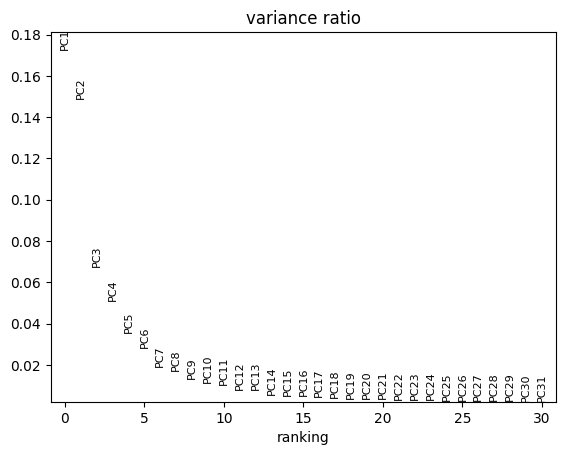

In [253]:
sc.pp.pca(adata_sub_organ)
sc.pl.pca_variance_ratio(adata_sub_organ)
sc.pp.neighbors(adata_sub_organ,n_pcs=12)
sc.tl.umap(adata_sub_organ)

In [170]:
adata_sub_organ.obs.cell_type.value_counts()

cell_type
granulocyte                                            693
monocyte                                               492
hematopoietic precursor cell                           373
granulocytopoietic cell                                358
proerythroblast                                        251
late pro-B cell                                        249
promonocyte                                            244
macrophage                                             214
T cell                                                 178
erythroblast                                           147
immature B cell                                        106
Fraction A pre-pro B cell                               65
early pro-B cell                                        59
basophil                                                54
B cell                                                  43
basal cell of epidermis                                 25
keratinocyte                                  

#### trans target to uhaf cell types

In [254]:
organ_name = 'Marrow'

In [172]:
new_cts = adata_sub_organ.obs["cell_type"].unique().tolist()
print(new_cts)

['Fraction A pre-pro B cell', 'monocyte', 'promonocyte', 'hematopoietic precursor cell', 'granulocyte', 'granulocytopoietic cell', 'late pro-B cell', 'proerythroblast', 'stromal cell', 'erythroblast', 'kidney loop of Henle ascending limb epithelial cell', 'early pro-B cell', 'T cell', 'macrophage', 'basophil', 'hepatocyte', 'endothelial cell', 'immature B cell', 'nan', 'mesenchymal stem cell', 'kidney collecting duct epithelial cell', 'keratinocyte', 'bladder urothelial cell', 'basal cell of epidermis', 'lung endothelial cell', 'B cell', 'DN1 thymic pro-T cell', 'natural killer cell', 'leukocyte', 'basal cell', 'immature T cell', 'kidney proximal straight tubule epithelial cell', 'non-classical monocyte', 'kidney capillary endothelial cell', 'bladder cell', 'luminal epithelial cell of mammary gland', 'mesangial cell', 'type II pneumocyte']


In [283]:
prompt = f"My cell types in the {organ_name} are: \n {new_cts},\n Please map uHAF nodes for my cell types. Give me a json dict of the mapping nodes."
print(prompt)

My cell types in the Lung are: 
 ['myeloid cell', 'bladder urothelial cell', 'B cell', 'natural killer cell', 'T cell', 'alveolar macrophage', 'lung endothelial cell', 'stromal cell', 'non-classical monocyte', 'leukocyte', 'basal cell of epidermis', 'classical monocyte', 'ciliated columnar cell of tracheobronchial tree', 'type II pneumocyte', 'hepatocyte', 'endothelial cell', 'nan', 'mast cell', 'kidney proximal straight tubule epithelial cell', 'mesenchymal stem cell', 'macrophage', 'immature T cell', 'luminal epithelial cell of mammary gland', 'kidney collecting duct epithelial cell', 'bladder cell', 'basal cell', 'monocyte', 'granulocyte', 'keratinocyte', 'kidney loop of Henle ascending limb epithelial cell', 'kidney capillary endothelial cell', 'fibroblast', 'granulocytopoietic cell'],
 Please map uHAF nodes for my cell types. Give me a json dict of the mapping nodes.


In [336]:
print(adata_sub_organ.obs['cell_type_from_scMulan'].unique().tolist())

['Multipotent progenitor (MPP)', 'Monocyte', 'Monocyte-dendritic progenitor (MDP)', 'Naive B cell', 'Granulocyte', 'Erythroblast', 'Erythroid-like cell', 'Pre-B cell', 'Plasmacytoid dendritic cell', 'Memory B cell', 'Memory CD8 T cell', 'Cholangiocyte', 'Dendritic cell', 'Vascular cell', 'Macrophage', 'Microglia', 'CD4 Treg', 'Multipotent lymphoid progenitor (MLP)', 'Naive CD8 T cell', 'NK cell', 'Common lymphoid progenitor (CLP)', 'Conventional dendritic cell', 'Erythrocyte', 'Pericyte', 'Neural progenitor cell', 'Megakaryocyte', 'Unclassified', 'Immune', 'Basophilic granulocyte', 'Kupffer cell', 'Neutrophilic myelocyte', 'Neuron', 'Classical monocyte', 'Basement membrane fibroblast', 'Erythroid progenitor cell', 'Plasma B cell', 'Memory CD4 T cell', 'Neutrophilic granulocyte', 'Secretory cell', 'Early T-cell precursor']


#### mapping dict from GPT

In [255]:
mapping_GPT = {
  "Fraction A pre-pro B cell": "Pre-B cell",
  "monocyte": "Monocyte",
  "promonocyte": "Monocyte",
  "hematopoietic precursor cell": "Multipotent progenitor (MPP)",
  "granulocyte": "Granulocyte",
  "granulocytopoietic cell": "Granulocyte",
  "late pro-B cell": "Pre-B cell",
  "proerythroblast": "Erythroid progenitor cell",
  "stromal cell": "Stromal cell",
  "erythroblast": "Erythroblast",
  "kidney loop of Henle ascending limb epithelial cell": "Epithelial cell",
  "early pro-B cell": "Pre-B cell",
  "T cell": "T cell",
  "macrophage": "Macrophage",
  "basophil": "Basophilic granulocyte",
  "hepatocyte": "Hepatocyte",
  "endothelial cell": "Endothelial cell",
  "immature B cell": "Naive B cell",
  "nan": "Unclassified",
  "mesenchymal stem cell": "Multipotent progenitor (MPP)",
  "kidney collecting duct epithelial cell": "Epithelial cell",
  "keratinocyte": "Epithelial cell",
  "bladder urothelial cell": "Epithelial cell",
  "basal cell of epidermis": "Epithelial cell",
  "lung endothelial cell": "Endothelial cell",
  "B cell": "B cell",
  "DN1 thymic pro-T cell": "T cell",
  "natural killer cell": "NK cell",
  "leukocyte": "Leukocyte",
  "basal cell": "Epithelial cell",
  "immature T cell": "T cell",
  "kidney proximal straight tubule epithelial cell": "Epithelial cell",
  "non-classical monocyte": "Monocyte",
  "kidney capillary endothelial cell": "Endothelial cell",
  "bladder cell": "Epithelial cell",
  "luminal epithelial cell of mammary gland": "Epithelial cell",
  "mesangial cell": "Stromal cell",
  "type II pneumocyte": "Epithelial cell",
  "Plasmacytoid dendritic cell": "Dendritic cell",
  "Monocyte": "Monocyte",
  "Monocyte-dendritic progenitor (MDP)": "Monocyte",
  "Granulocyte": "Granulocyte",
  "Pre-B cell": "Pre-B cell",
  "Erythroid-like cell": "Erythroid progenitor cell",
  "Dendritic cell": "Dendritic cell",
  "Naive B cell": "Naive B cell",
  "Memory CD8 T cell": "T cell",
  "Vascular cell": "Endothelial cell",
  "Kupffer cell": "Macrophage",
  "Multipotent progenitor (MPP)": "Multipotent progenitor (MPP)",
  "Erythroblast": "Erythroblast",
  "CD4 Treg": "T cell",
  "Memory B cell": "B cell",
  "Basophilic granulocyte": "Basophilic granulocyte",
  "Erythroid progenitor cell": "Erythroid progenitor cell",
  "NK cell": "NK cell",
  "Naive CD8 T cell": "T cell",
  "Basement membrane fibroblast": "Stromal cell",
  "Macrophage": "Macrophage",
  "Conventional dendritic cell": "Dendritic cell"
}




In [256]:
GPT_MCT = {
  "Fraction A pre-pro B cell": "Immune cell",
  "monocyte": "Immune cell",
  "promonocyte": "Immune cell",
  "hematopoietic precursor cell": "Progenitor cell",
  "granulocyte": "Immune cell",
  "granulocytopoietic cell": "Immune cell",
  "late pro-B cell": "Immune cell",
  "proerythroblast": "Progenitor cell",
  "stromal cell": "Stromal cell",
  "erythroblast": "Progenitor cell",
  "kidney loop of Henle ascending limb epithelial cell": "Epithelial cell",
  "early pro-B cell": "Immune cell",
  "T cell": "Immune cell",
  "macrophage": "Immune cell",
  "basophil": "Immune cell",
  "hepatocyte": "Epithelial cell",
  "endothelial cell": "Endothelial cell",
  "immature B cell": "Immune cell",
  "nan": "Unclassified",
  "mesenchymal stem cell": "Progenitor cell",
  "kidney collecting duct epithelial cell": "Epithelial cell",
  "keratinocyte": "Epithelial cell",
  "bladder urothelial cell": "Epithelial cell",
  "basal cell of epidermis": "Epithelial cell",
  "lung endothelial cell": "Endothelial cell",
  "B cell": "Immune cell",
  "DN1 thymic pro-T cell": "Immune cell",
  "natural killer cell": "Immune cell",
  "leukocyte": "Immune cell",
  "basal cell": "Epithelial cell",
  "immature T cell": "Immune cell",
  "kidney proximal straight tubule epithelial cell": "Epithelial cell",
  "non-classical monocyte": "Immune cell",
  "kidney capillary endothelial cell": "Endothelial cell",
  "bladder cell": "Epithelial cell",
  "luminal epithelial cell of mammary gland": "Epithelial cell",
  "mesangial cell": "Stromal cell",
  "type II pneumocyte": "Epithelial cell",
  "Plasmacytoid dendritic cell": "Immune cell",
  "Monocyte": "Immune cell",
  "Monocyte-dendritic progenitor (MDP)": "Progenitor cell",
  "Granulocyte": "Immune cell",
  "Pre-B cell": "Immune cell",
  "Erythroid-like cell": "Progenitor cell",
  "Dendritic cell": "Immune cell",
  "Naive B cell": "Immune cell",
  "Memory CD8 T cell": "Immune cell",
  "Vascular cell": "Endothelial cell",
  "Kupffer cell": "Immune cell",
  "Multipotent progenitor (MPP)": "Progenitor cell",
  "Erythroblast": "Progenitor cell",
  "CD4 Treg": "Immune cell",
  "Memory B cell": "Immune cell",
  "Basophilic granulocyte": "Immune cell",
  "Erythroid progenitor cell": "Progenitor cell",
  "NK cell": "Immune cell",
  "Naive CD8 T cell": "Immune cell",
  "Basement membrane fibroblast": "Stromal cell",
  "Macrophage": "Immune cell",
  "Conventional dendritic cell": "Immune cell"
}



In [257]:
adata_sub_organ.obs['cell_type_GPT'] = adata_sub_organ.obs['cell_type'].apply(trans_name, args=(mapping_GPT,))
adata_sub_organ.obs['scmulan_GPT'] = adata_sub_organ.obs['cell_type_from_mulan_smoothing'].apply(trans_name, args=(mapping_GPT,))

In [258]:
adata_sub_organ.obs['cell_type_MCT_GPT'] = adata_sub_organ.obs['cell_type'].apply(trans_name, args=(GPT_MCT,))
adata_sub_organ.obs['scmulan_MCT_GPT'] = adata_sub_organ.obs['cell_type_from_mulan_smoothing'].apply(trans_name, args=(GPT_MCT,))

/tmp/ipykernel_945746/1813990048.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", len(unique_labels))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plo

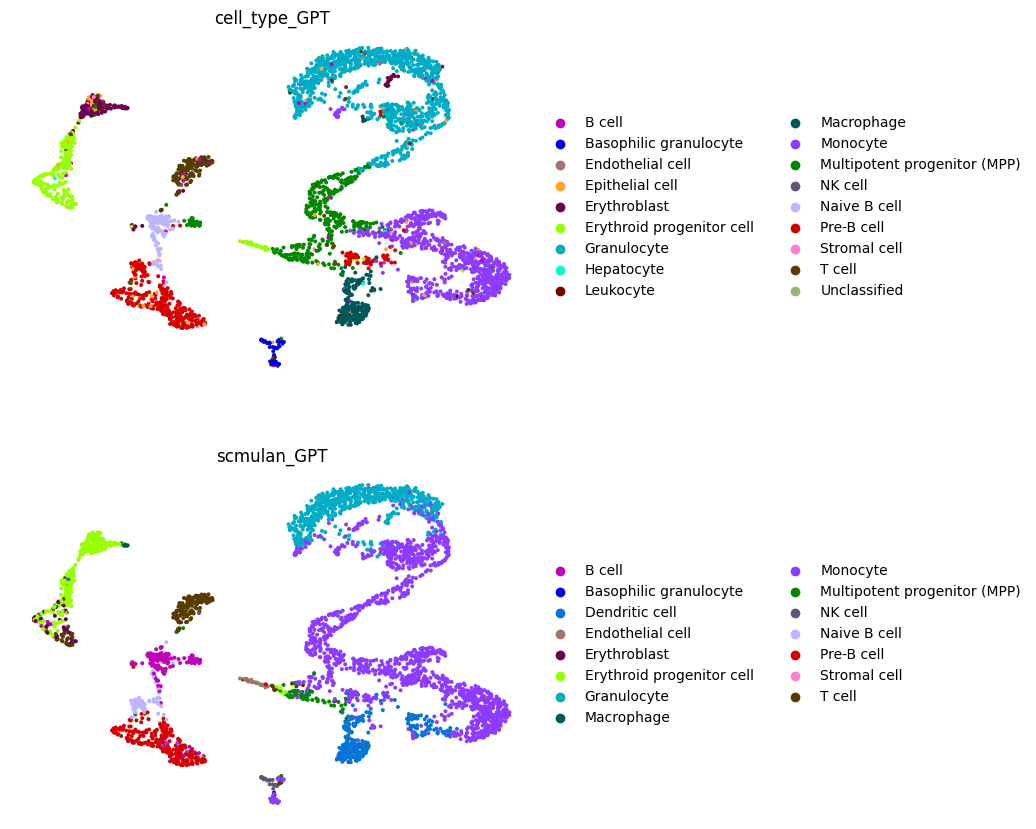

In [184]:
# unified colors of cell types
unique_labels = pd.concat([adata_sub_organ.obs["cell_type_GPT"], adata_sub_organ.obs["scmulan_GPT"]]).unique()
colors = plt.cm.get_cmap("hsv", len(unique_labels))
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

colors = cc.glasbey[:len(unique_labels)]
color_map = dict(zip(unique_labels, colors))

adata_sub_organ.obs["cell_type_GPT_colors"] = adata_sub_organ.obs["cell_type_GPT"].map(color_map)
adata_sub_organ.obs["scmulan_GPT_colors"] = adata_sub_organ.obs["scmulan_GPT"].map(color_map)

# draw umap
sc.pl.umap(adata_sub_organ,color=["cell_type_GPT","scmulan_GPT"], palette=color_map, ncols=1, frameon=False,save="_TM_cell_type_Marrow.pdf")

/tmp/ipykernel_945746/4075897646.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", len(unique_labels))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plo

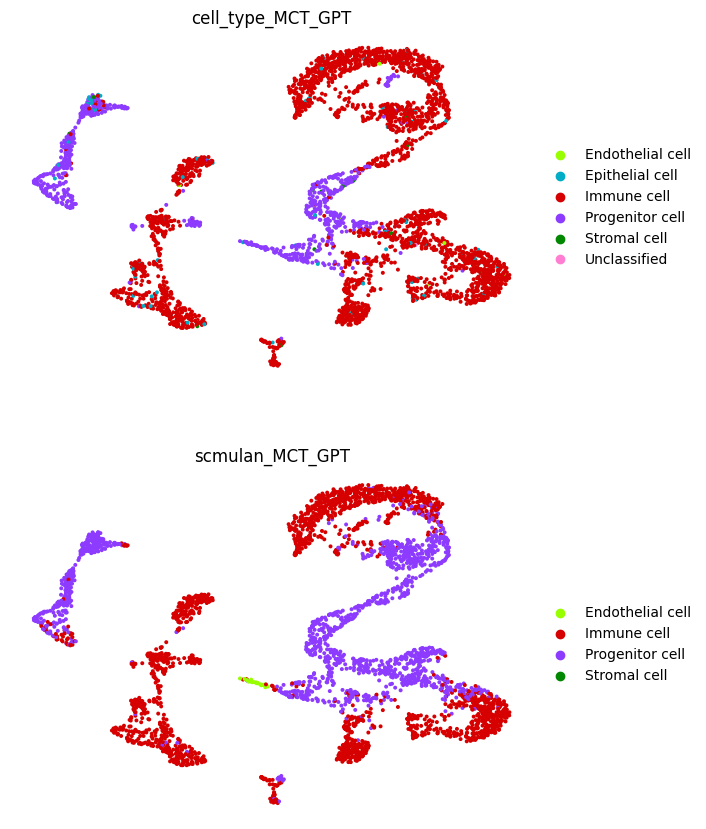

In [185]:
# unified colors of cell types
unique_labels = pd.concat([adata_sub_organ.obs["cell_type_MCT_GPT"], adata_sub_organ.obs["scmulan_MCT_GPT"]]).unique()
colors = plt.cm.get_cmap("hsv", len(unique_labels))
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

colors = cc.glasbey[:len(unique_labels)]
color_map = dict(zip(unique_labels, colors))

adata_sub_organ.obs["cell_type_MCT_GPT_colors"] = adata_sub_organ.obs["cell_type_MCT_GPT"].map(color_map)
adata_sub_organ.obs["scmulan_MCT_GPT_colors"] = adata_sub_organ.obs["scmulan_MCT_GPT"].map(color_map)

# draw umap
sc.pl.umap(adata_sub_organ,color=["cell_type_MCT_GPT","scmulan_MCT_GPT"], palette=color_map, ncols=1, frameon=False,save="_TM_MCT_Marrow.pdf")

In [263]:
targets_ = adata_sub_organ.obs['cell_type_GPT'].tolist()
preds_ = adata_sub_organ.obs['scmulan_GPT'].tolist()

In [264]:
labels = list(Counter(targets_ + preds_).keys())
true_labels = list(Counter(targets_).keys())

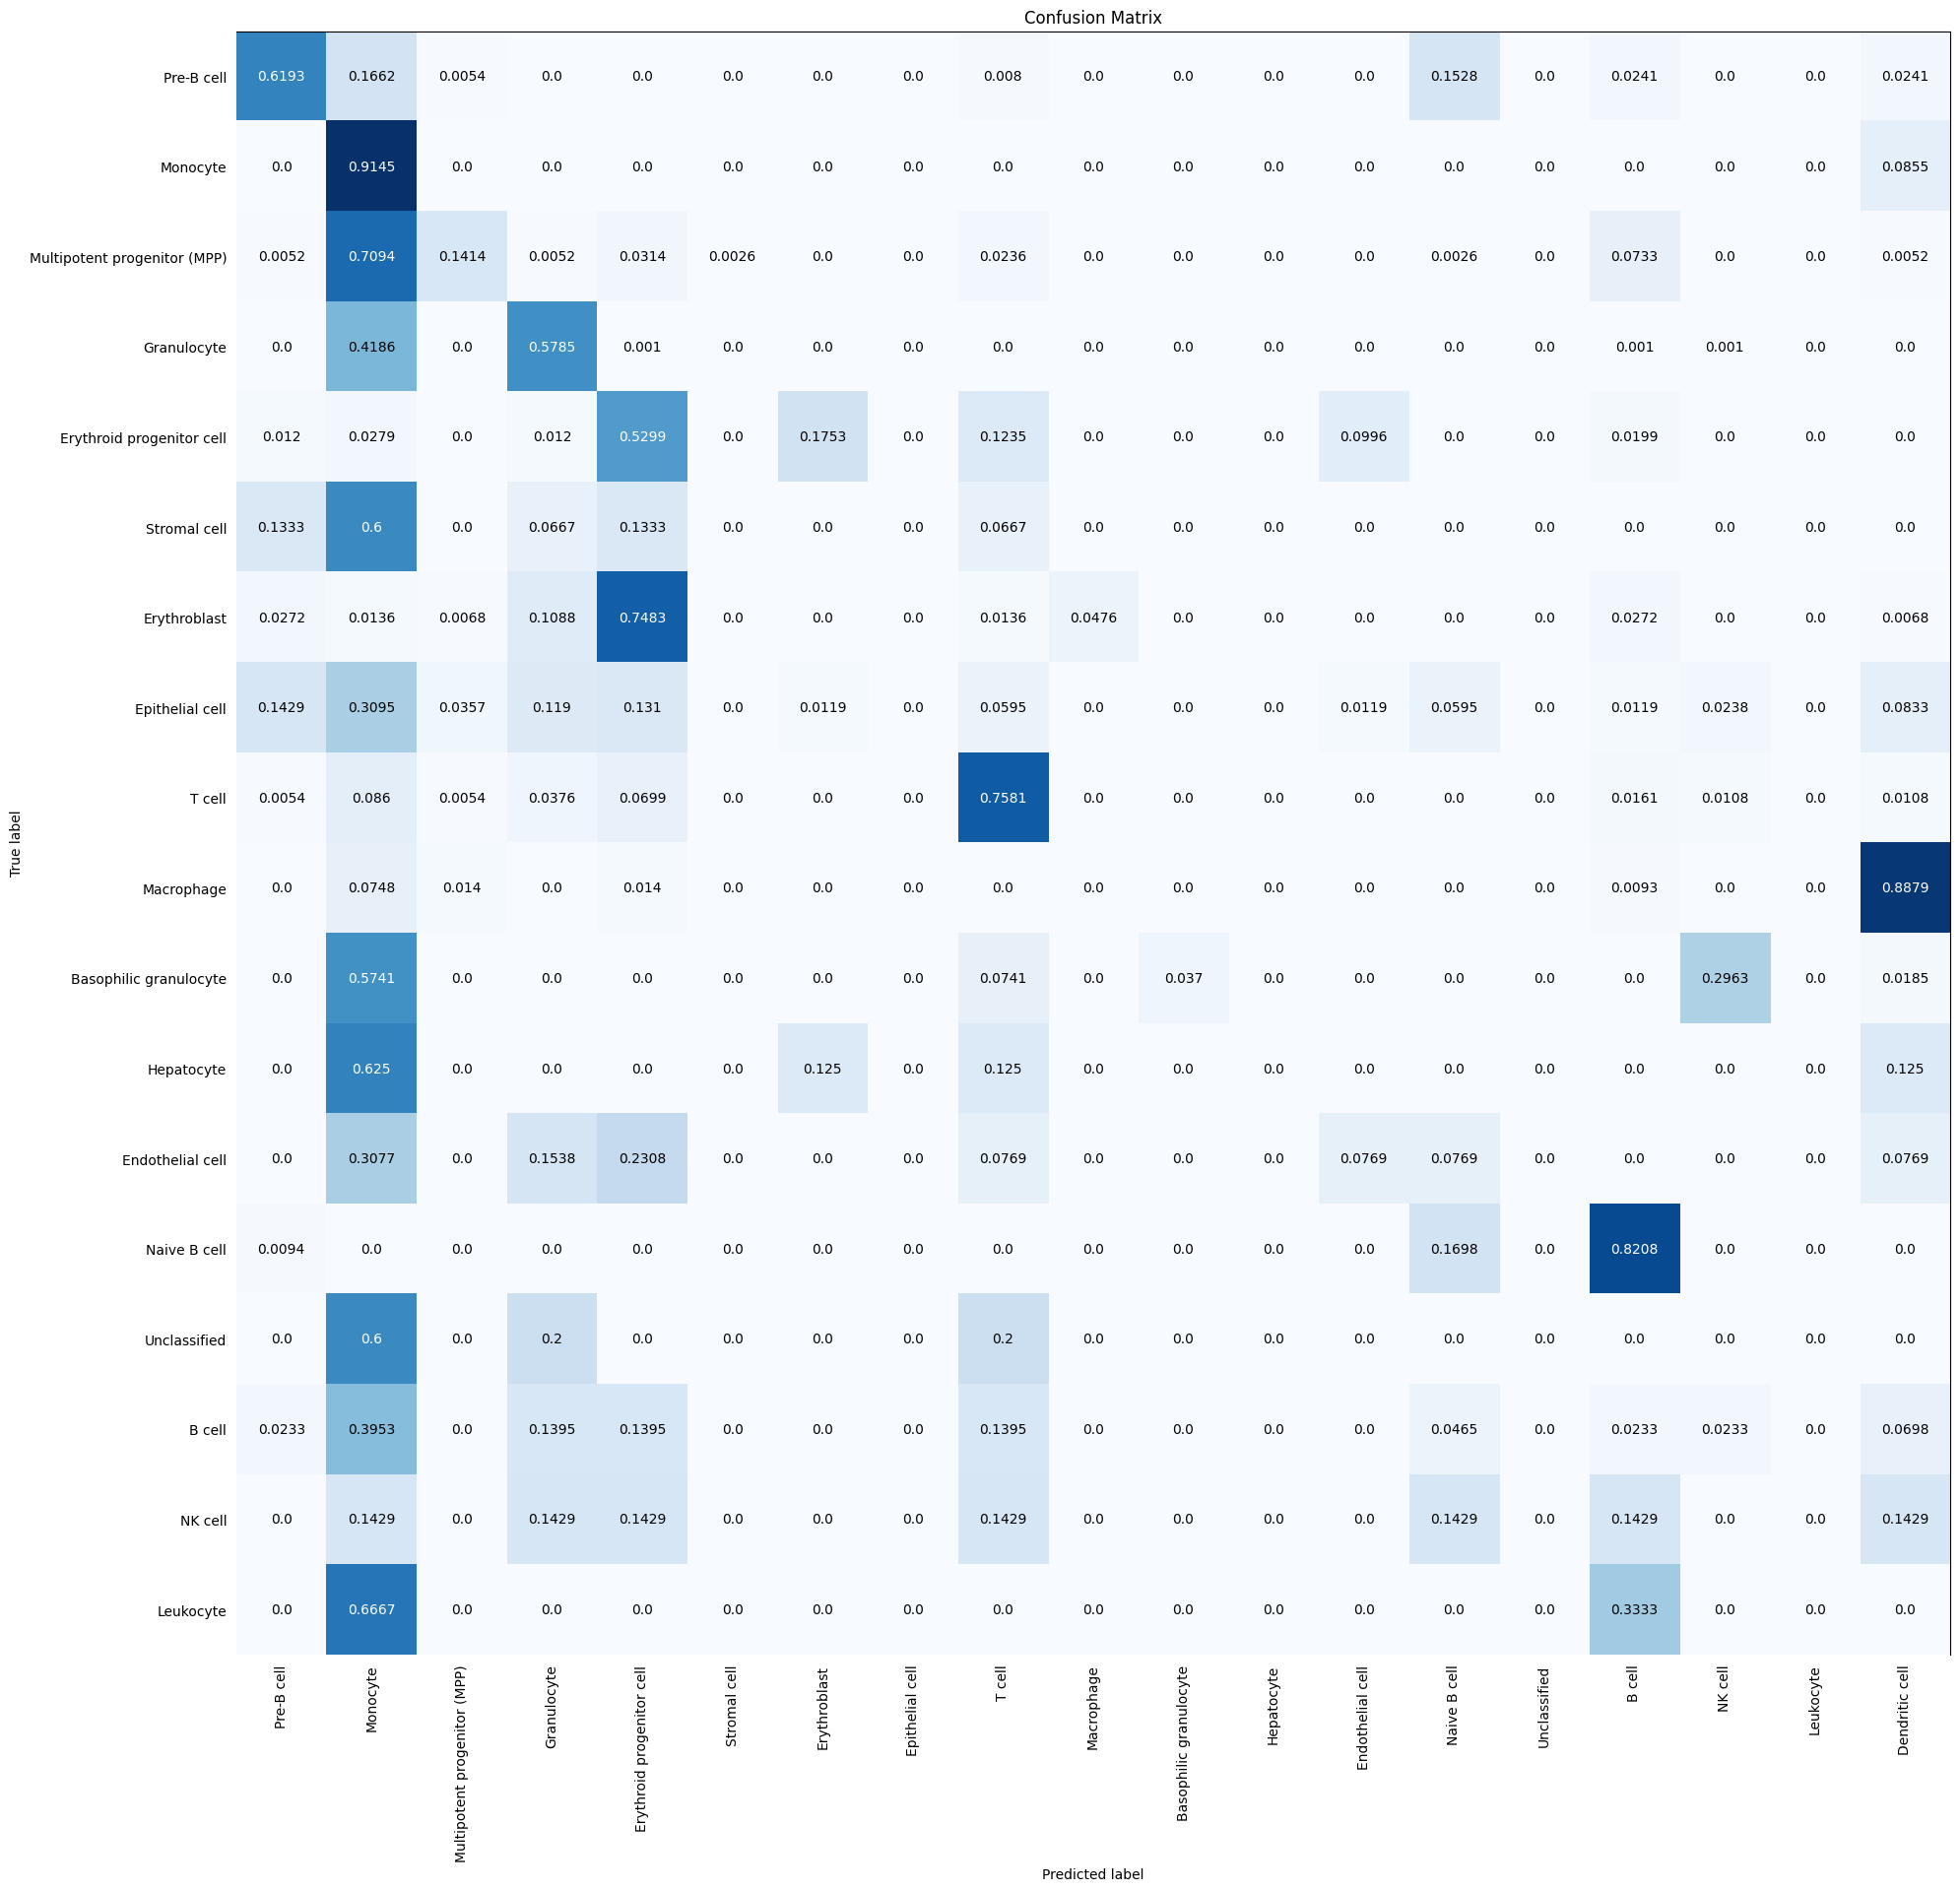

In [271]:
cm = confusion_matrix(targets_, preds_, labels=labels)
pd.DataFrame(cm[[labels.index(lab) for lab in true_labels]], index=true_labels, columns=labels).to_csv("TM_cross_species/CM.cell_type.Marrow.csv")
plot_confusion_matrix(cm, true_labels, labels, "Confusion Matrix",saving="figures/ConfusionMatrix_celltype_Marrow.pdf")

In [190]:
accuracy = accuracy_score(targets_, preds_)
recall = recall_score(targets_, preds_, average='weighted')
f1 = f1_score(targets_, preds_, average='weighted')

accuracy, recall, f1

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5063876053275347, 0.5063876053275347, 0.4955136275302316)

In [272]:
targets_ = adata_sub_organ.obs['cell_type_MCT_GPT'].tolist()
preds_ = adata_sub_organ.obs['scmulan_MCT_GPT'].tolist()

In [273]:
labels = list(Counter(targets_ + preds_).keys())
true_labels = list(Counter(targets_).keys())

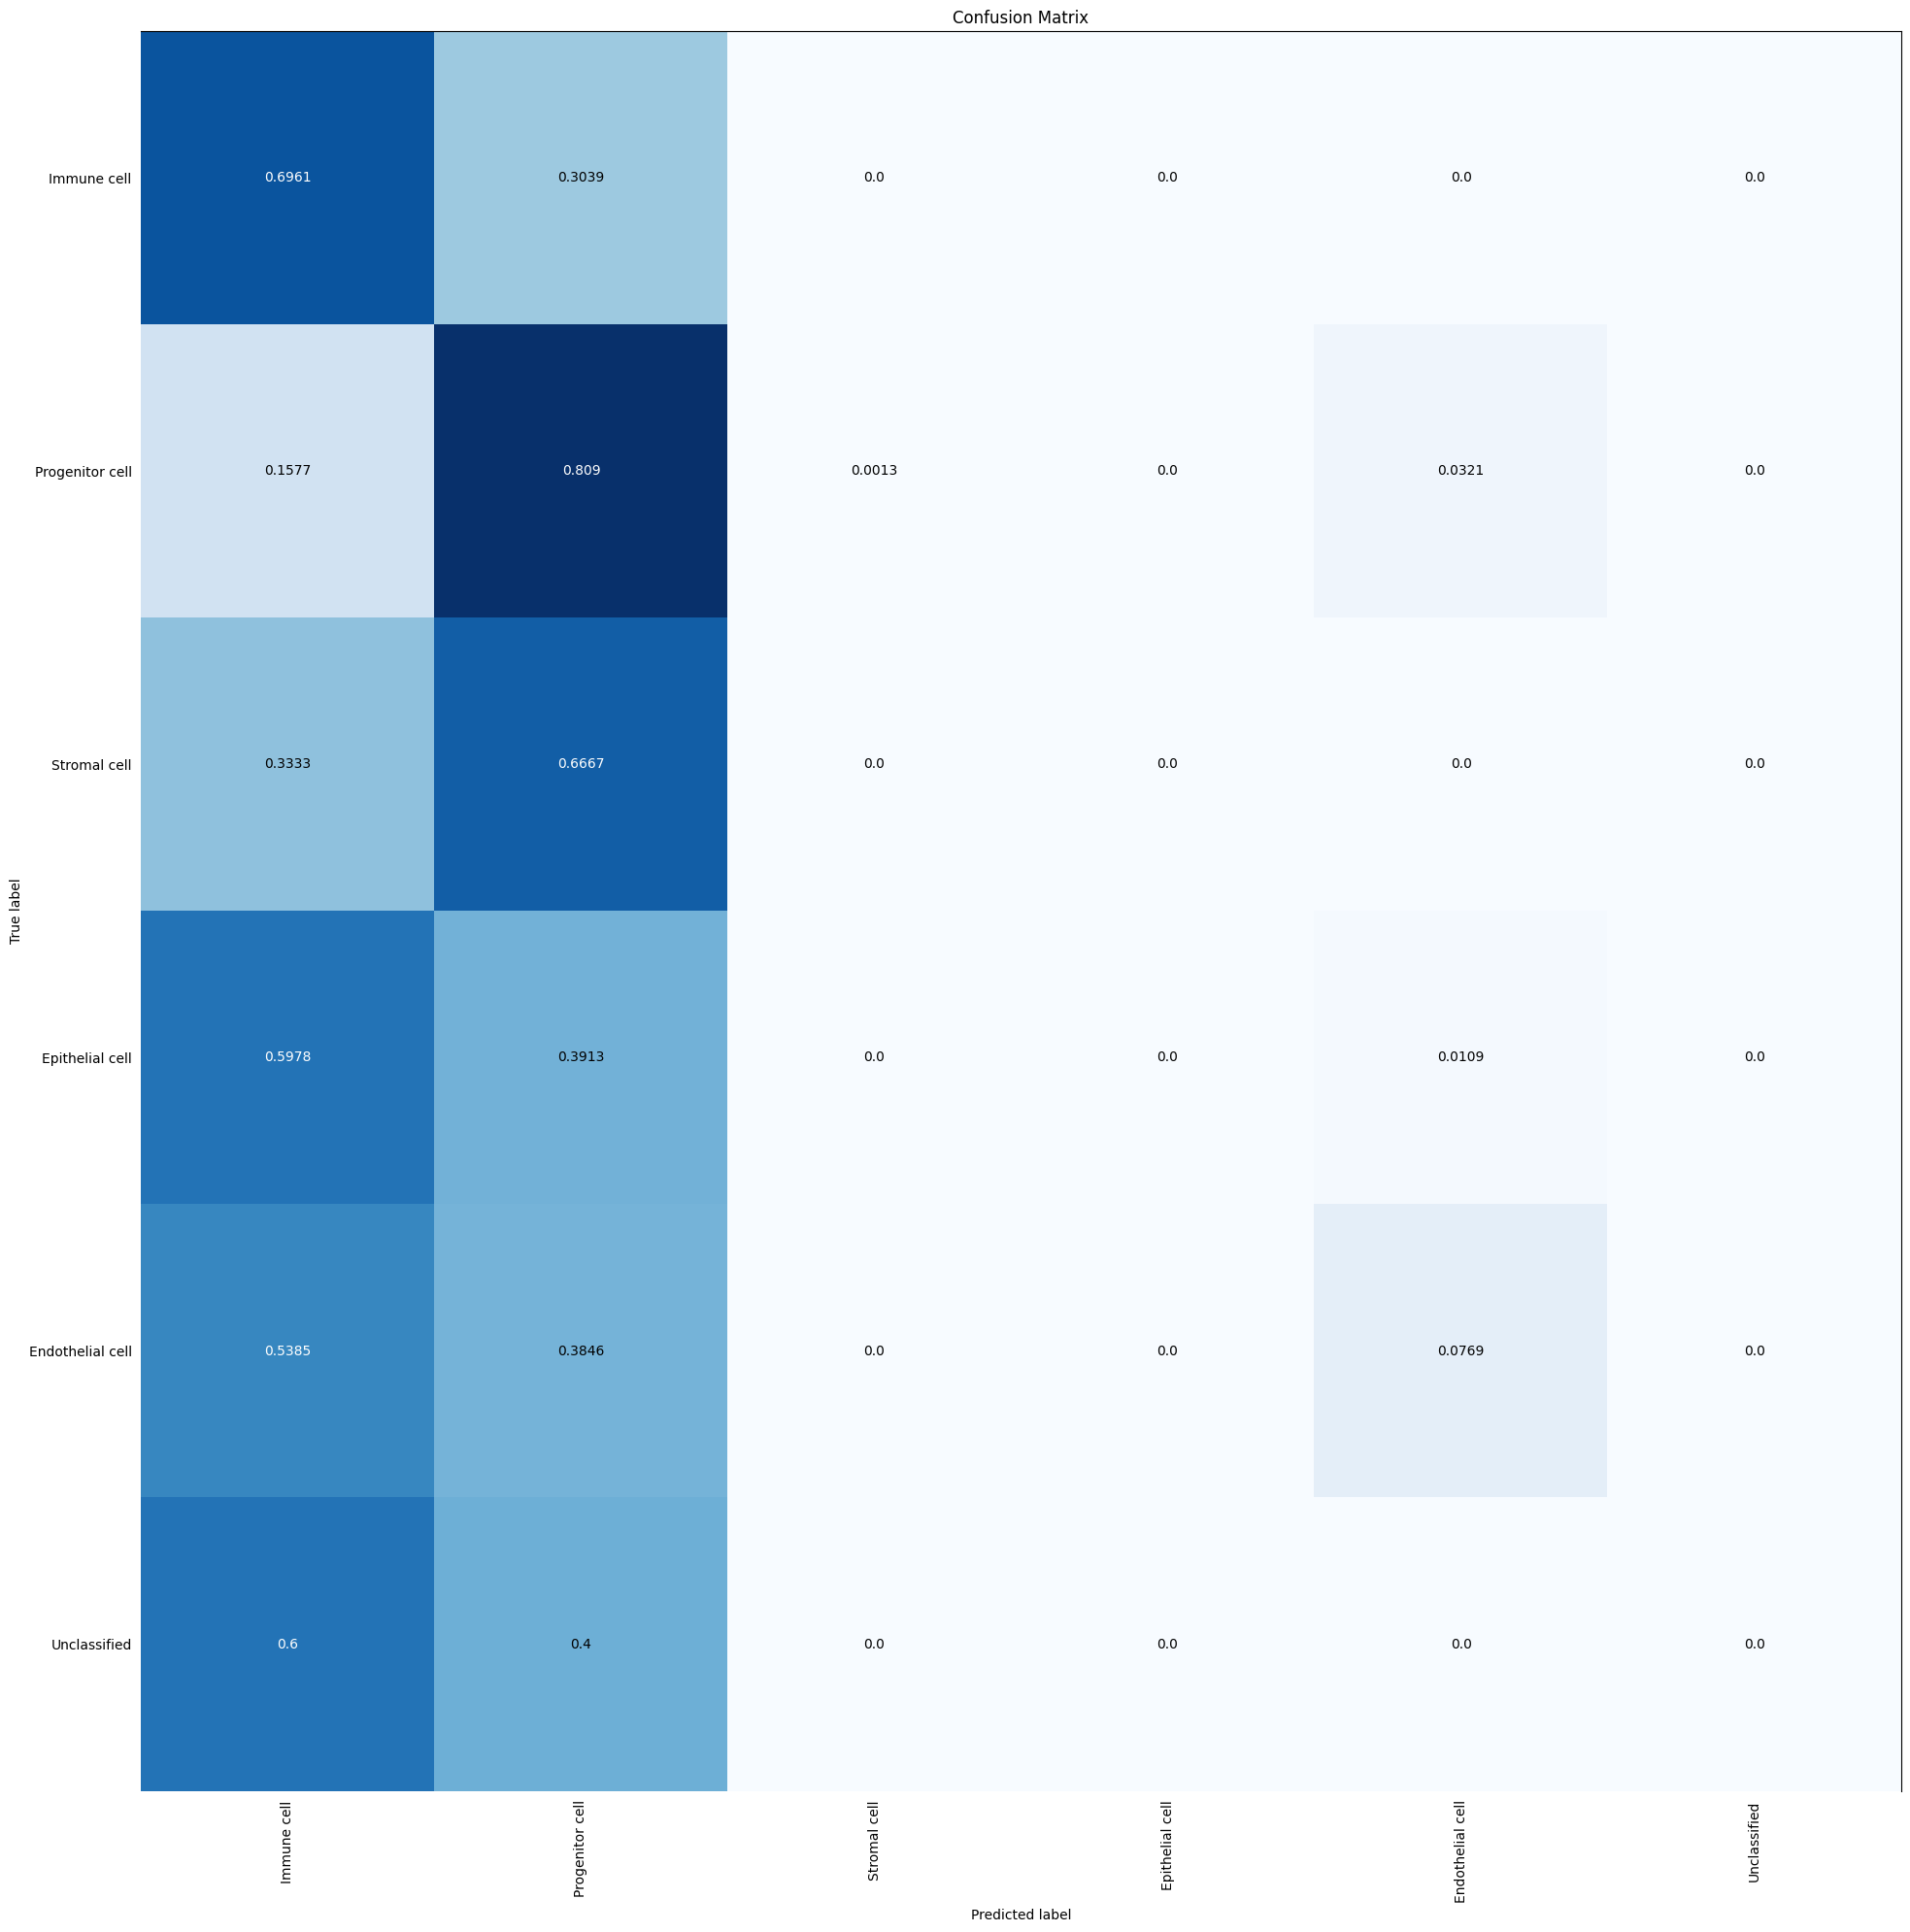

In [274]:
cm = confusion_matrix(targets_, preds_, labels=labels)
pd.DataFrame(cm[[labels.index(lab) for lab in true_labels]], index=true_labels, columns=labels).to_csv("TM_cross_species/CM.MCT.Marrow.csv")
plot_confusion_matrix(cm, true_labels, labels, "Confusion Matrix",saving="figures/ConfusionMatrix_MCT_Marrow.pdf")

In [194]:
accuracy = accuracy_score(targets_, preds_)
recall = recall_score(targets_, preds_, average='weighted')
f1 = f1_score(targets_, preds_, average='weighted')

accuracy, recall, f1

(0.696656700190269, 0.696656700190269, 0.7106799840684314)

### Metrics visualization

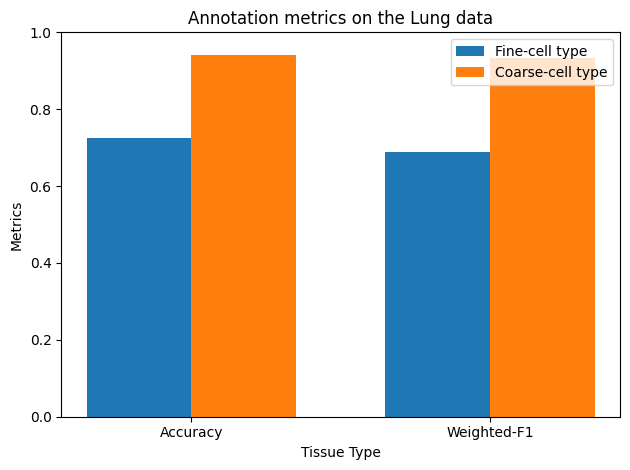

In [319]:
# Data from the table
categories = ['Accuracy', 'Weighted-F1']
fine_cell_type = [0.726, 0.689]
coarse_cell_type = [0.940, 0.933]

# X-axis positions for the bars
x = np.arange(len(categories))

# Bar width and spacing
bar_width = 0.35

# Plotting the bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width/2, fine_cell_type, bar_width, label='Fine-cell type')
bar2 = ax.bar(x + bar_width/2, coarse_cell_type, bar_width, label='Coarse-cell type')

# Adding labels and title
ax.set_xlabel('Tissue Type')
ax.set_ylabel('Metrics')
ax.set_title('Annotation metrics on the Lung data')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.set_ylim(0,1)
plt.tight_layout()
plt.savefig("figures/Lung_anno_metrics.pdf")
# Display the plot
plt.show()

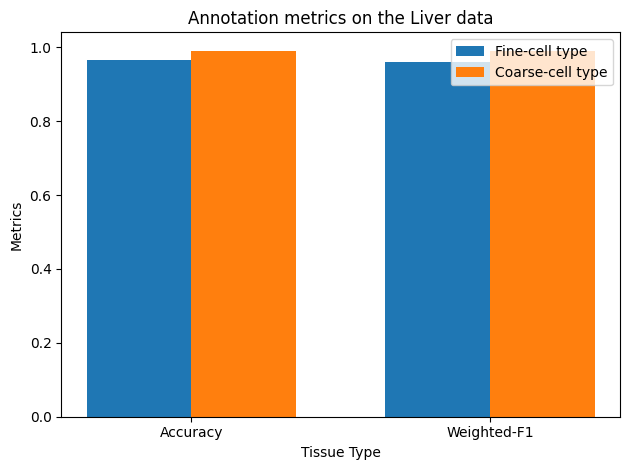

In [316]:
# Data from the table
categories = ['Accuracy',  'Weighted-F1']
fine_cell_type = [0.967, 0.959]
coarse_cell_type = [0.991, 0.990]

# X-axis positions for the bars
x = np.arange(len(categories))

# Bar width and spacing
bar_width = 0.35

# Plotting the bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width/2, fine_cell_type, bar_width, label='Fine-cell type')
bar2 = ax.bar(x + bar_width/2, coarse_cell_type, bar_width, label='Coarse-cell type')

# Adding labels and title
ax.set_xlabel('Tissue Type')
ax.set_ylabel('Metrics')
ax.set_title('Annotation metrics on the Liver data')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.tight_layout()
plt.savefig("figures/Liver_anno_metrics.pdf")
# Display the plot
plt.show()

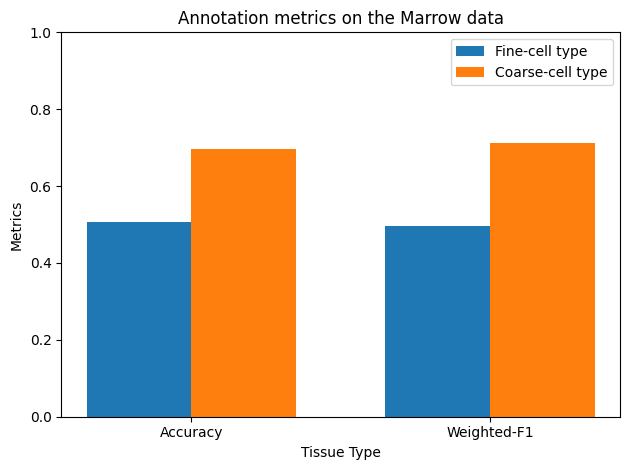

In [318]:
# Data from the table
categories = ['Accuracy',  'Weighted-F1']
fine_cell_type = [0.506, 0.495]
coarse_cell_type = [0.697, 0.711]

# X-axis positions for the bars
x = np.arange(len(categories))

# Bar width and spacing
bar_width = 0.35

# Plotting the bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width/2, fine_cell_type, bar_width, label='Fine-cell type')
bar2 = ax.bar(x + bar_width/2, coarse_cell_type, bar_width, label='Coarse-cell type')

# Adding labels and title
ax.set_xlabel('Tissue Type')
ax.set_ylabel('Metrics')
ax.set_title('Annotation metrics on the Marrow data')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.set_ylim(0,1)
plt.tight_layout()
plt.savefig("figures/Marrow_anno_metrics.pdf")
# Display the plot
plt.show()